# Genetics & Genomics – Genomics Project fall 2024  
# Where do my single cells come from? 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from sklearn.cluster import KMeans
from scipy import stats
from statsmodels.stats.multitest import multipletests
import warnings
import matplotlib as mpl
import json
import requests

warnings.filterwarnings('ignore')

## 1) Load and visualize the data

### 1a)

In [2]:
# Load the tab-separated count matrix and store it in a pandas DataFrame
count_matrix_path = 'data/single_cell_count_matrix.txt'
count_matrix = pd.read_csv(count_matrix_path, sep='\t')
# Display first rows and columns of DataFrame
count_matrix.head()

Ensembl IDs  cell_1  cell_2  cell_3  cell_4  cell_5  cell_6  cell_7  \
0  ENSMUSG00000085214       0       0       0       0       0       0       0   
1  ENSMUSG00000090401       1       0       0       0       0    4069       0   
2  ENSMUSG00000021252    1548       0       0       2       4       0       2   
3  ENSMUSG00000007777    5685       0     537       0    7360       0    3881   
4  ENSMUSG00000043644       0       0       0       0       0       0     570   

   cell_8  cell_9  ...  cell_45  cell_46  cell_47  cell_48  cell_49  cell_50  \
0       0       0  ...        0        0        0        0        0        0   
1       0       3  ...       34        0        0     1034        0        0   
2       0     644  ...      252      568        0        1        0        0   
3       0   11152  ...       49     7146        6    13772       10       22   
4       0       0  ...        0      640        0       17        0        0   

   cell_51  cell_52  cell_53  cell_54  
0        0        0        0        0  
1      129      135        0        0  
2        2        5        0      935  
3    16380     7100        0       11  
4     4574      185        0        0  

[5 rows x 55 columns]

In [3]:
print("The number of rows of the matrix is {}, and the number of columns is {}. The total size is {}.".format(count_matrix.shape[0], count_matrix.shape[1], count_matrix.size))

The number of rows of the matrix is 21783, and the number of columns is 55. The total size is 1198065.


### 1b)

In [4]:
# Assess type of data
print("The data type we have are {}, so they are raw read counts.".format(count_matrix.iloc[:, 1:].dtypes.value_counts().index.tolist()[0]))

The data type we have are int64, so they are raw read counts.


### 1c) Filtering & Normalization

In [5]:
# Filter: Remove the genes that are not expressed in any sample
index_to_drop = count_matrix[count_matrix.iloc[:, 1:].sum(axis=1) == 0].index
print("The genes that are not expressed in any sample are {}.".format(len(index_to_drop)))
count_matrix_filtered = count_matrix.drop(index_to_drop, axis=0)

The genes that are not expressed in any sample are 3545.


In [6]:
def plot_cumulative_sum(cumulative_sum, title, name):
    # Bar plot of cumulative sum
    fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
    (cumulative_sum / 10**6).plot.bar(ax=ax, rot=90)
    ax.set_xlabel("Samples")
    ax.set_ylabel("Cumulative Sum of Gene Counts (in counts per million)")
    ax.set_title(title)
    plt.savefig("figures/{}".format(name), format="png", dpi=300)
    plt.tight_layout()
    plt.show()

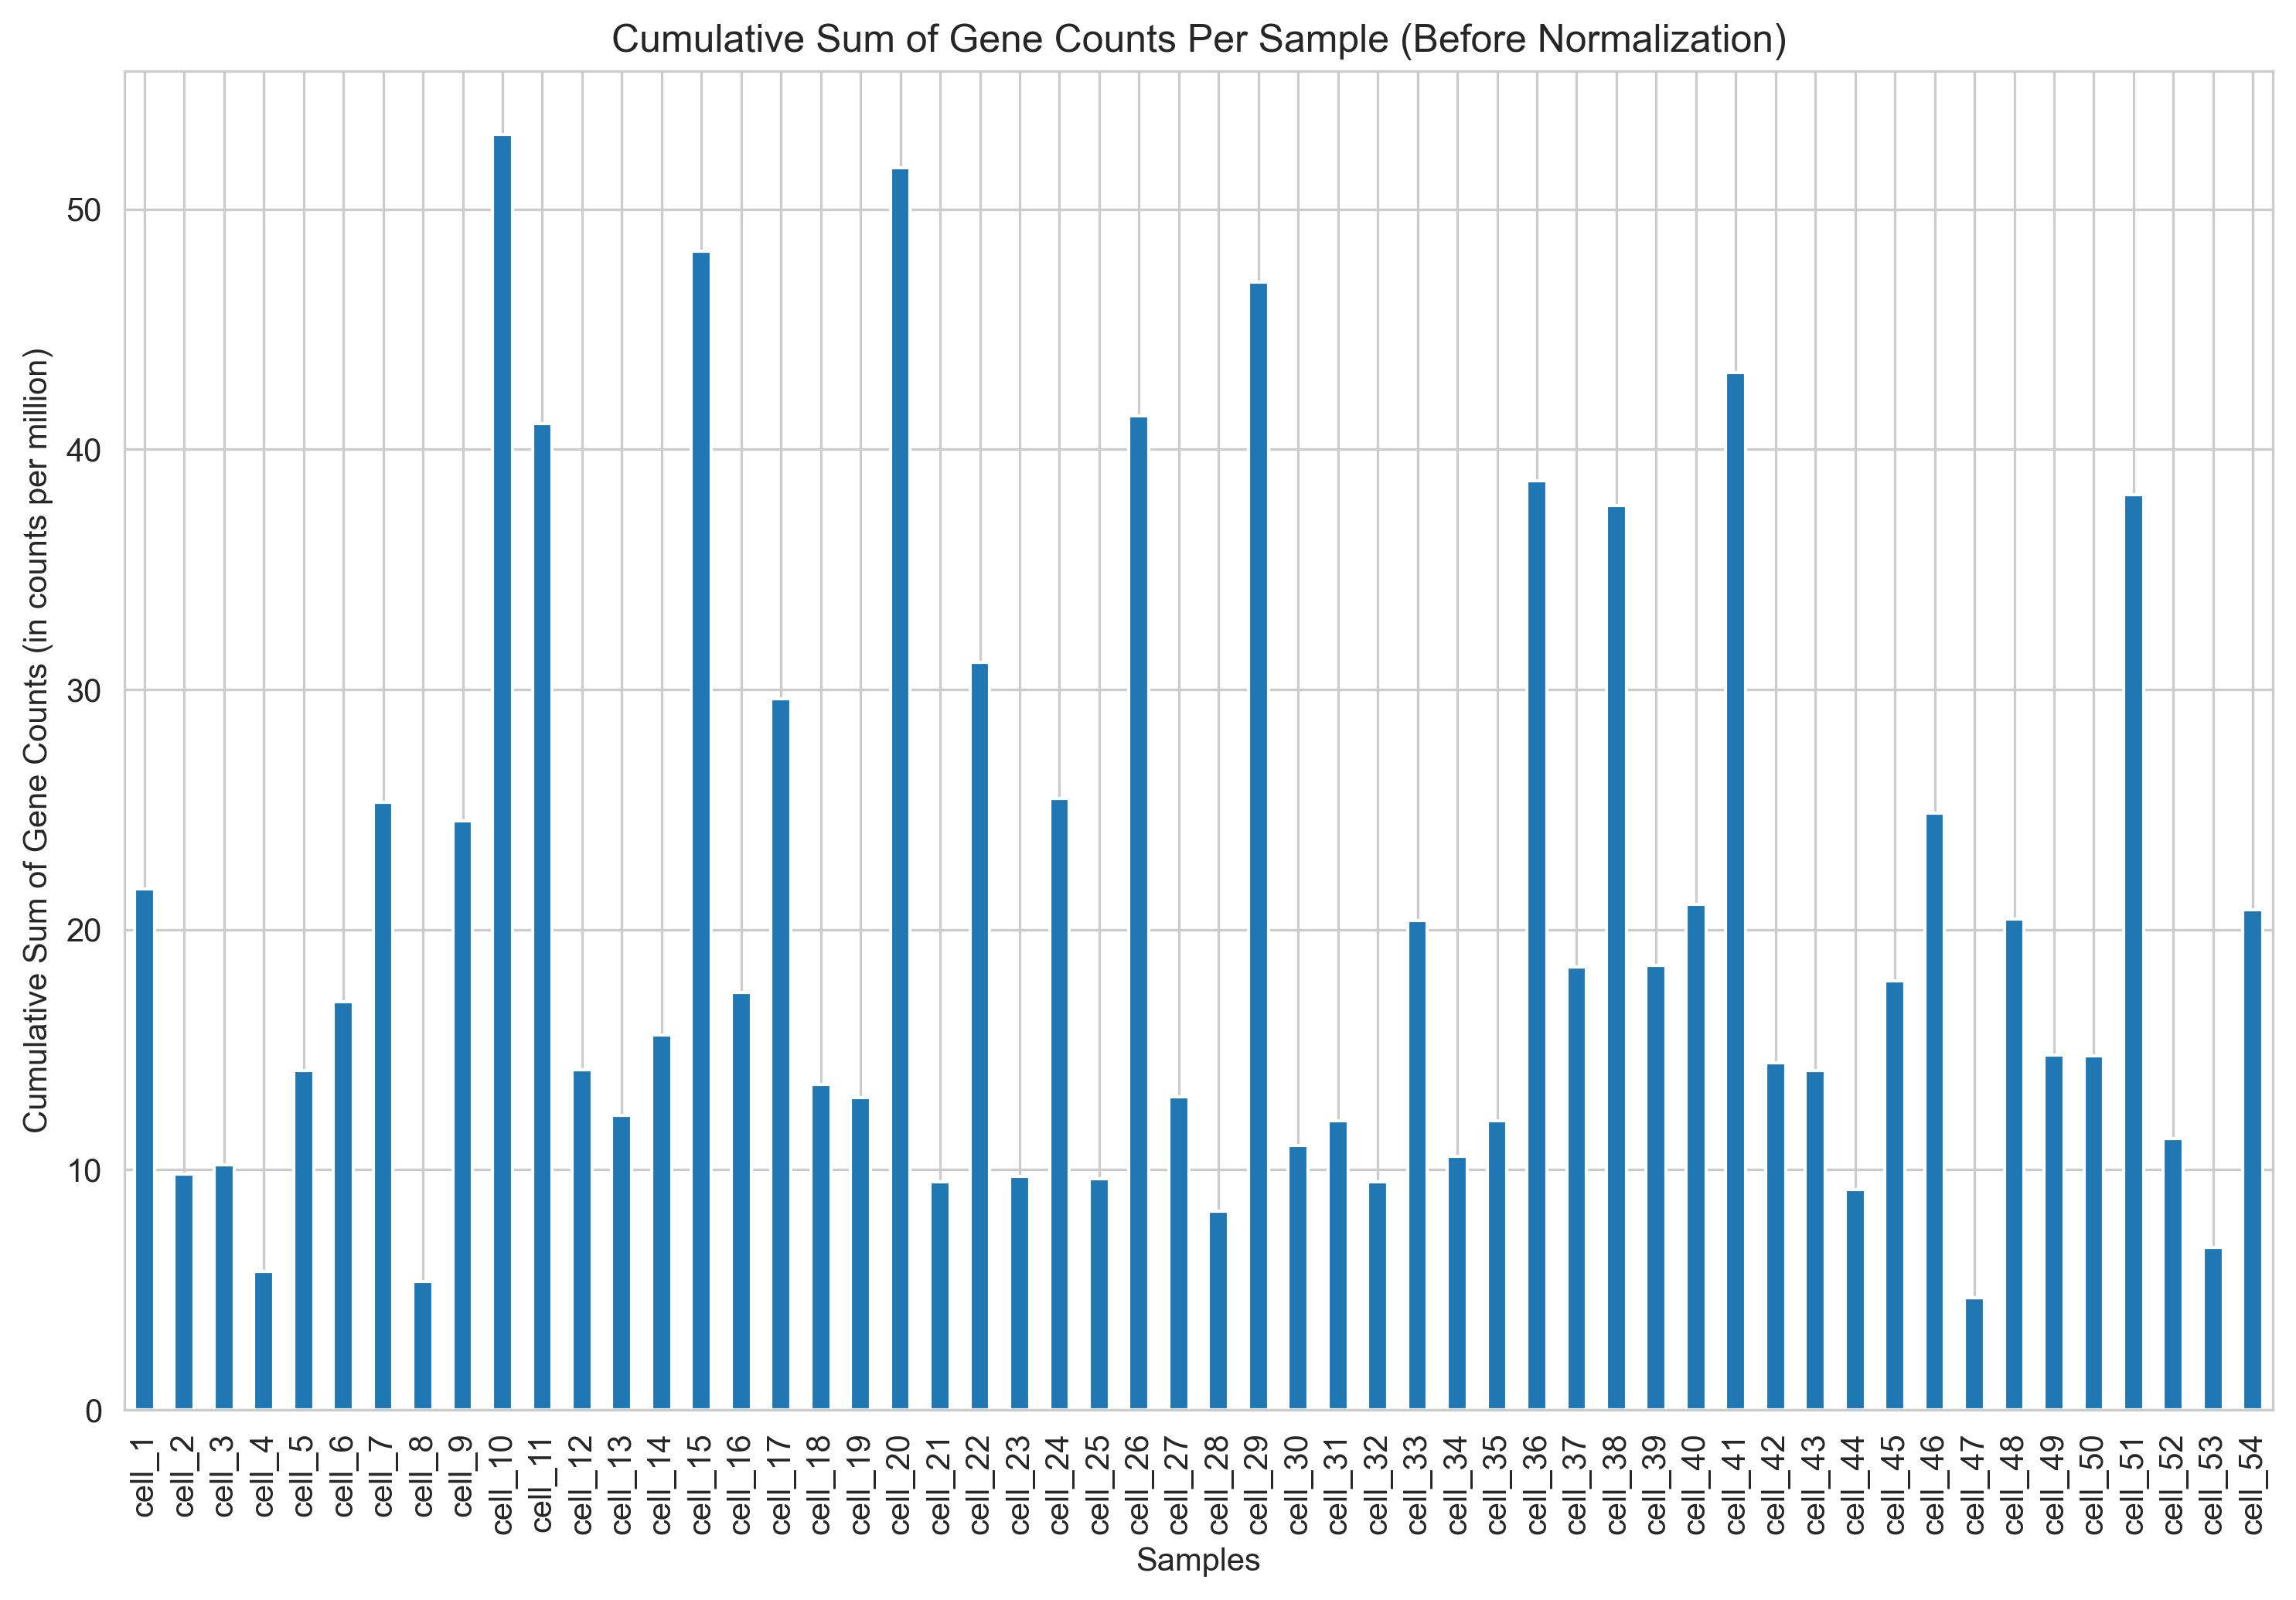

In [7]:
# Compute the sum of all the genes in a sample, for each sample
counts = count_matrix_filtered.iloc[:, 1:].sum(axis=0)
counts.name = "sum_counts"

# Bar plot of cumulative sum
plot_cumulative_sum(counts, "Cumulative Sum of Gene Counts Per Sample (Before Normalization)", "cumulative_sum_before_normalization.png")

In [8]:
# Compute variability
max_total_count = counts.max()
min_total_count = counts.min()
variation = (max_total_count - min_total_count) / max_total_count * 100
print("Since the cumulative counts vary significantly ({}%) between samples, normalization is recommended.".format(round(variation, 2)))

Since the cumulative counts vary significantly (91.21%) between samples, normalization is recommended.


In [9]:
# Count per Million Normalization
count_matrix_normalized = pd.concat([count_matrix_filtered[['Ensembl IDs']], 
                                     count_matrix_filtered.iloc[:, 1:].div(counts.values.astype(float), axis=1) * 10**6], axis=1)

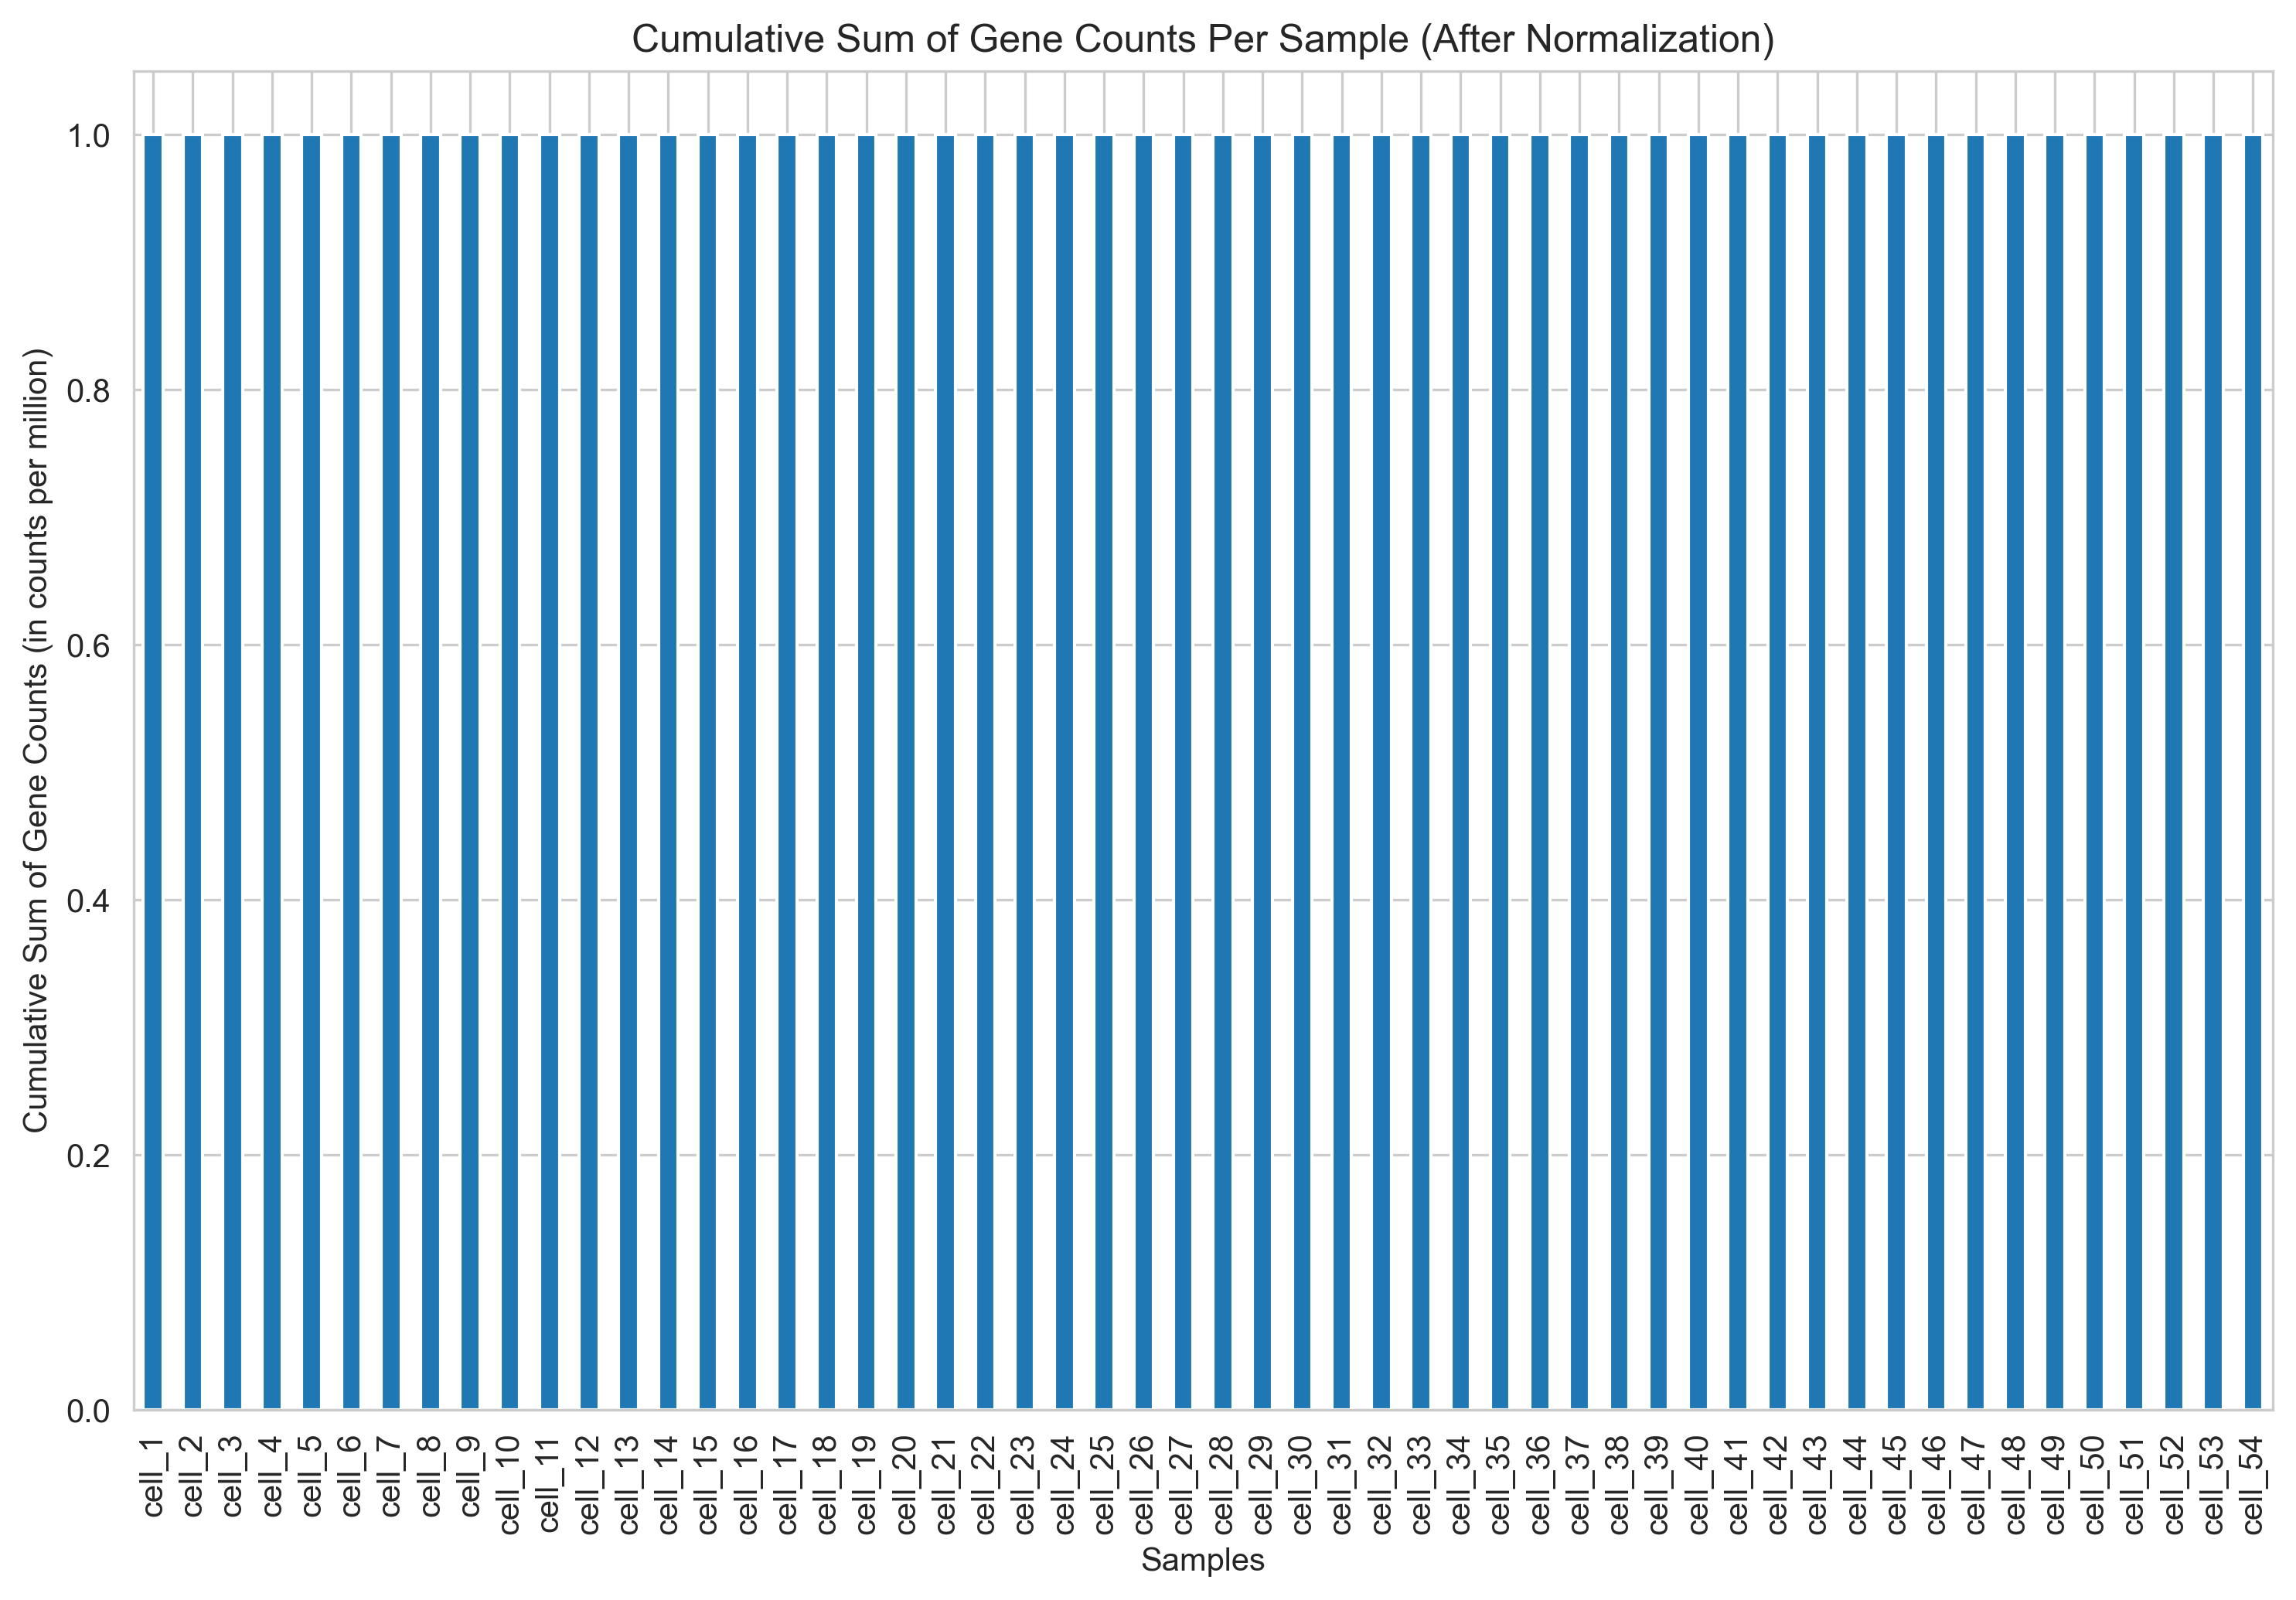

In [10]:
# Compute the sum of all the genes in a sample, for each sample, after normalization
counts_after_normalization = count_matrix_normalized.iloc[:, 1:].sum(axis=0)
counts_after_normalization.name = "sum_counts"

# Bar plot of cumulative sum after normalization
plot_cumulative_sum(counts_after_normalization, "Cumulative Sum of Gene Counts Per Sample (After Normalization)", "cumulative_sum_after_normalization.png")

After the normalization, there is a consistent sum of gene counts. In this way we have uniformity across samples.

### 1d) PCA on samples

In [11]:
def pca_plot(data, title, name, hue=None, legend=None):
    plt.figure(dpi=300, figsize=(10, 7))
    if legend is None:
        scatter = sns.scatterplot(data=data, x='PC1', y='PC2', s=100, hue=hue, palette='Set1', marker='o')
    else:
        scatter = sns.scatterplot(data=data, x='PC1', y='PC2', s=100, hue=hue, palette='viridis', marker='o')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    
    if legend is not None:
        plt.legend().remove()
        norm = mpl.colors.Normalize(vmin=data[hue].min(), vmax=data[hue].max())
        sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter.figure.axes[0])
        cbar.set_label('Gene Expression', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('figures/{}'.format(name), format="png", dpi=300)   
    plt.show()

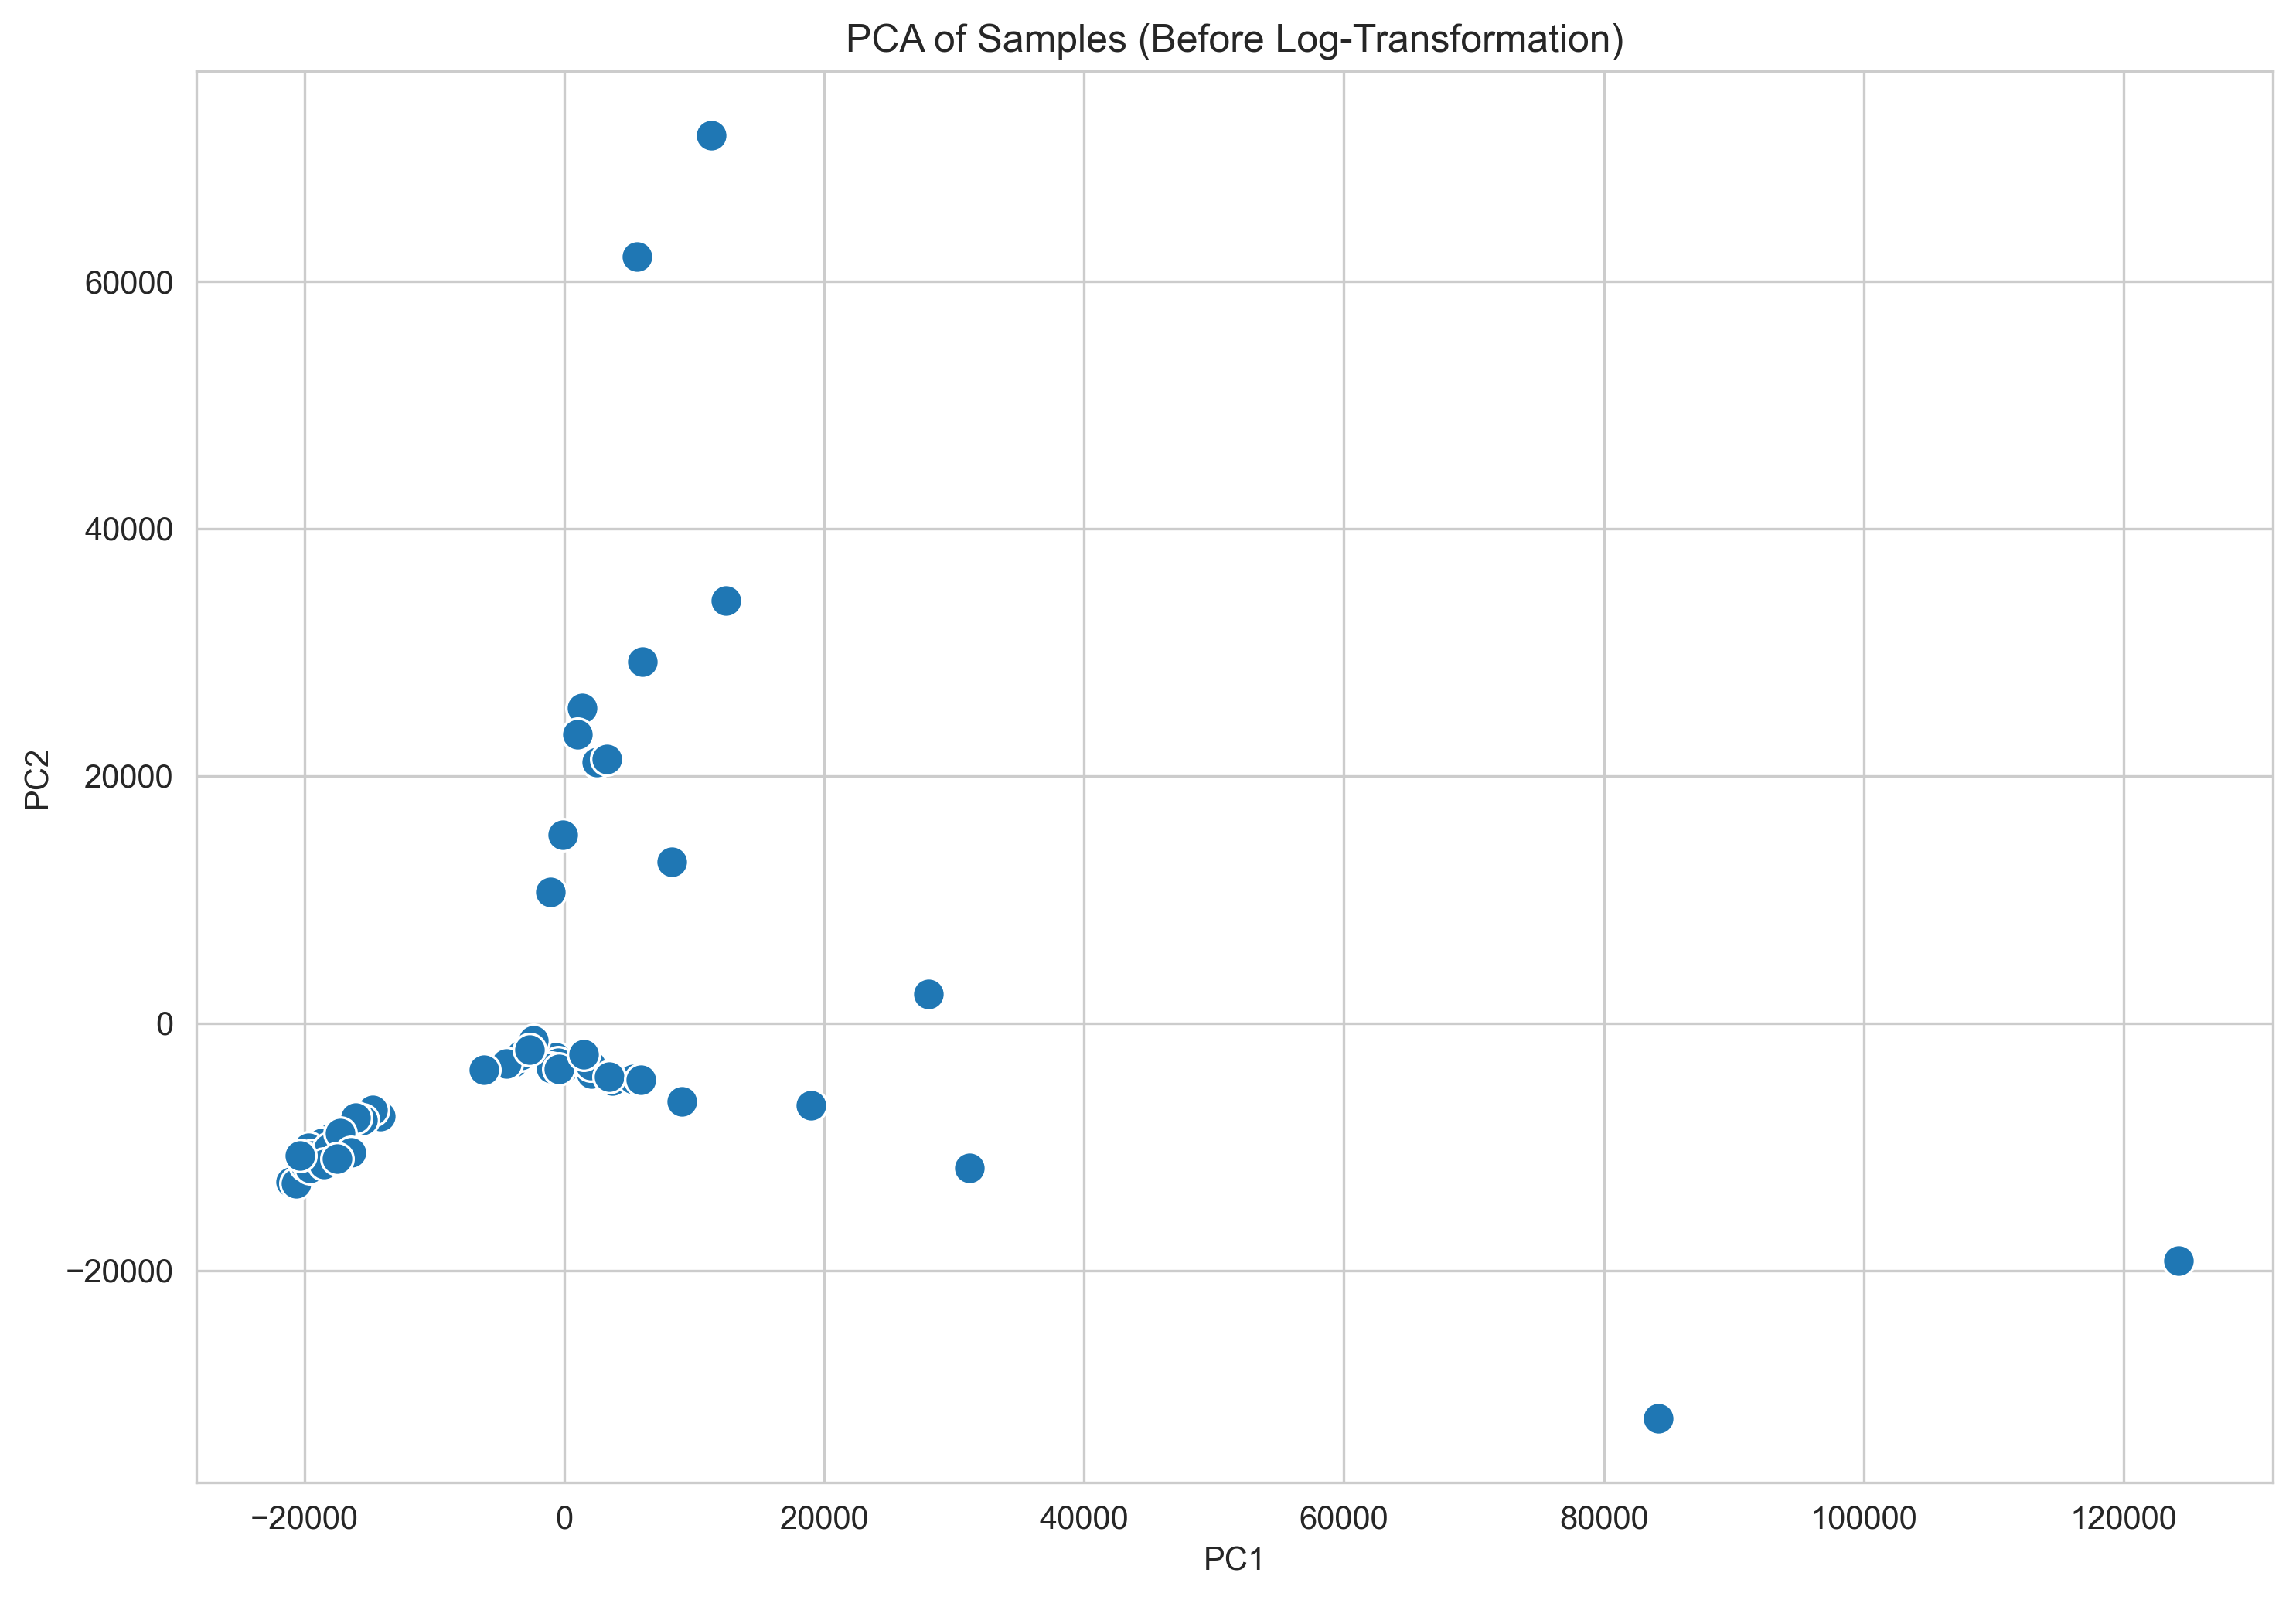

In [12]:
# Calculate the principal components (PCs) of the counts data matrix
matrix = count_matrix_normalized.iloc[:, 1:].T
pca = decomposition.PCA(n_components=2)
pca.fit(matrix)
transformed_data = pca.transform(matrix)
transformed_df = pd.DataFrame(transformed_data, index=matrix.index, columns=['PC1', 'PC2'])

# Plot the first two components
pca_plot(transformed_df, 'PCA of Samples (Before Log-Transformation)', 'pca_before_transformation.png')

Based on this PCA plot, the three clusters are not well-separated. Even after normalization, the raw data likely retains variability that hides cluster structure. Applying additional transformations, such as a log2(1+x) transformation, could improve the clustering.

### 1e) Transformation

In [13]:
# Perform a log2(1+x) transformation of data
count_matrix_log_transformed = pd.concat([count_matrix_normalized[['Ensembl IDs']], 
                                     count_matrix_normalized.iloc[:, 1:].map(lambda x: np.log2(1 + x))], axis=1)

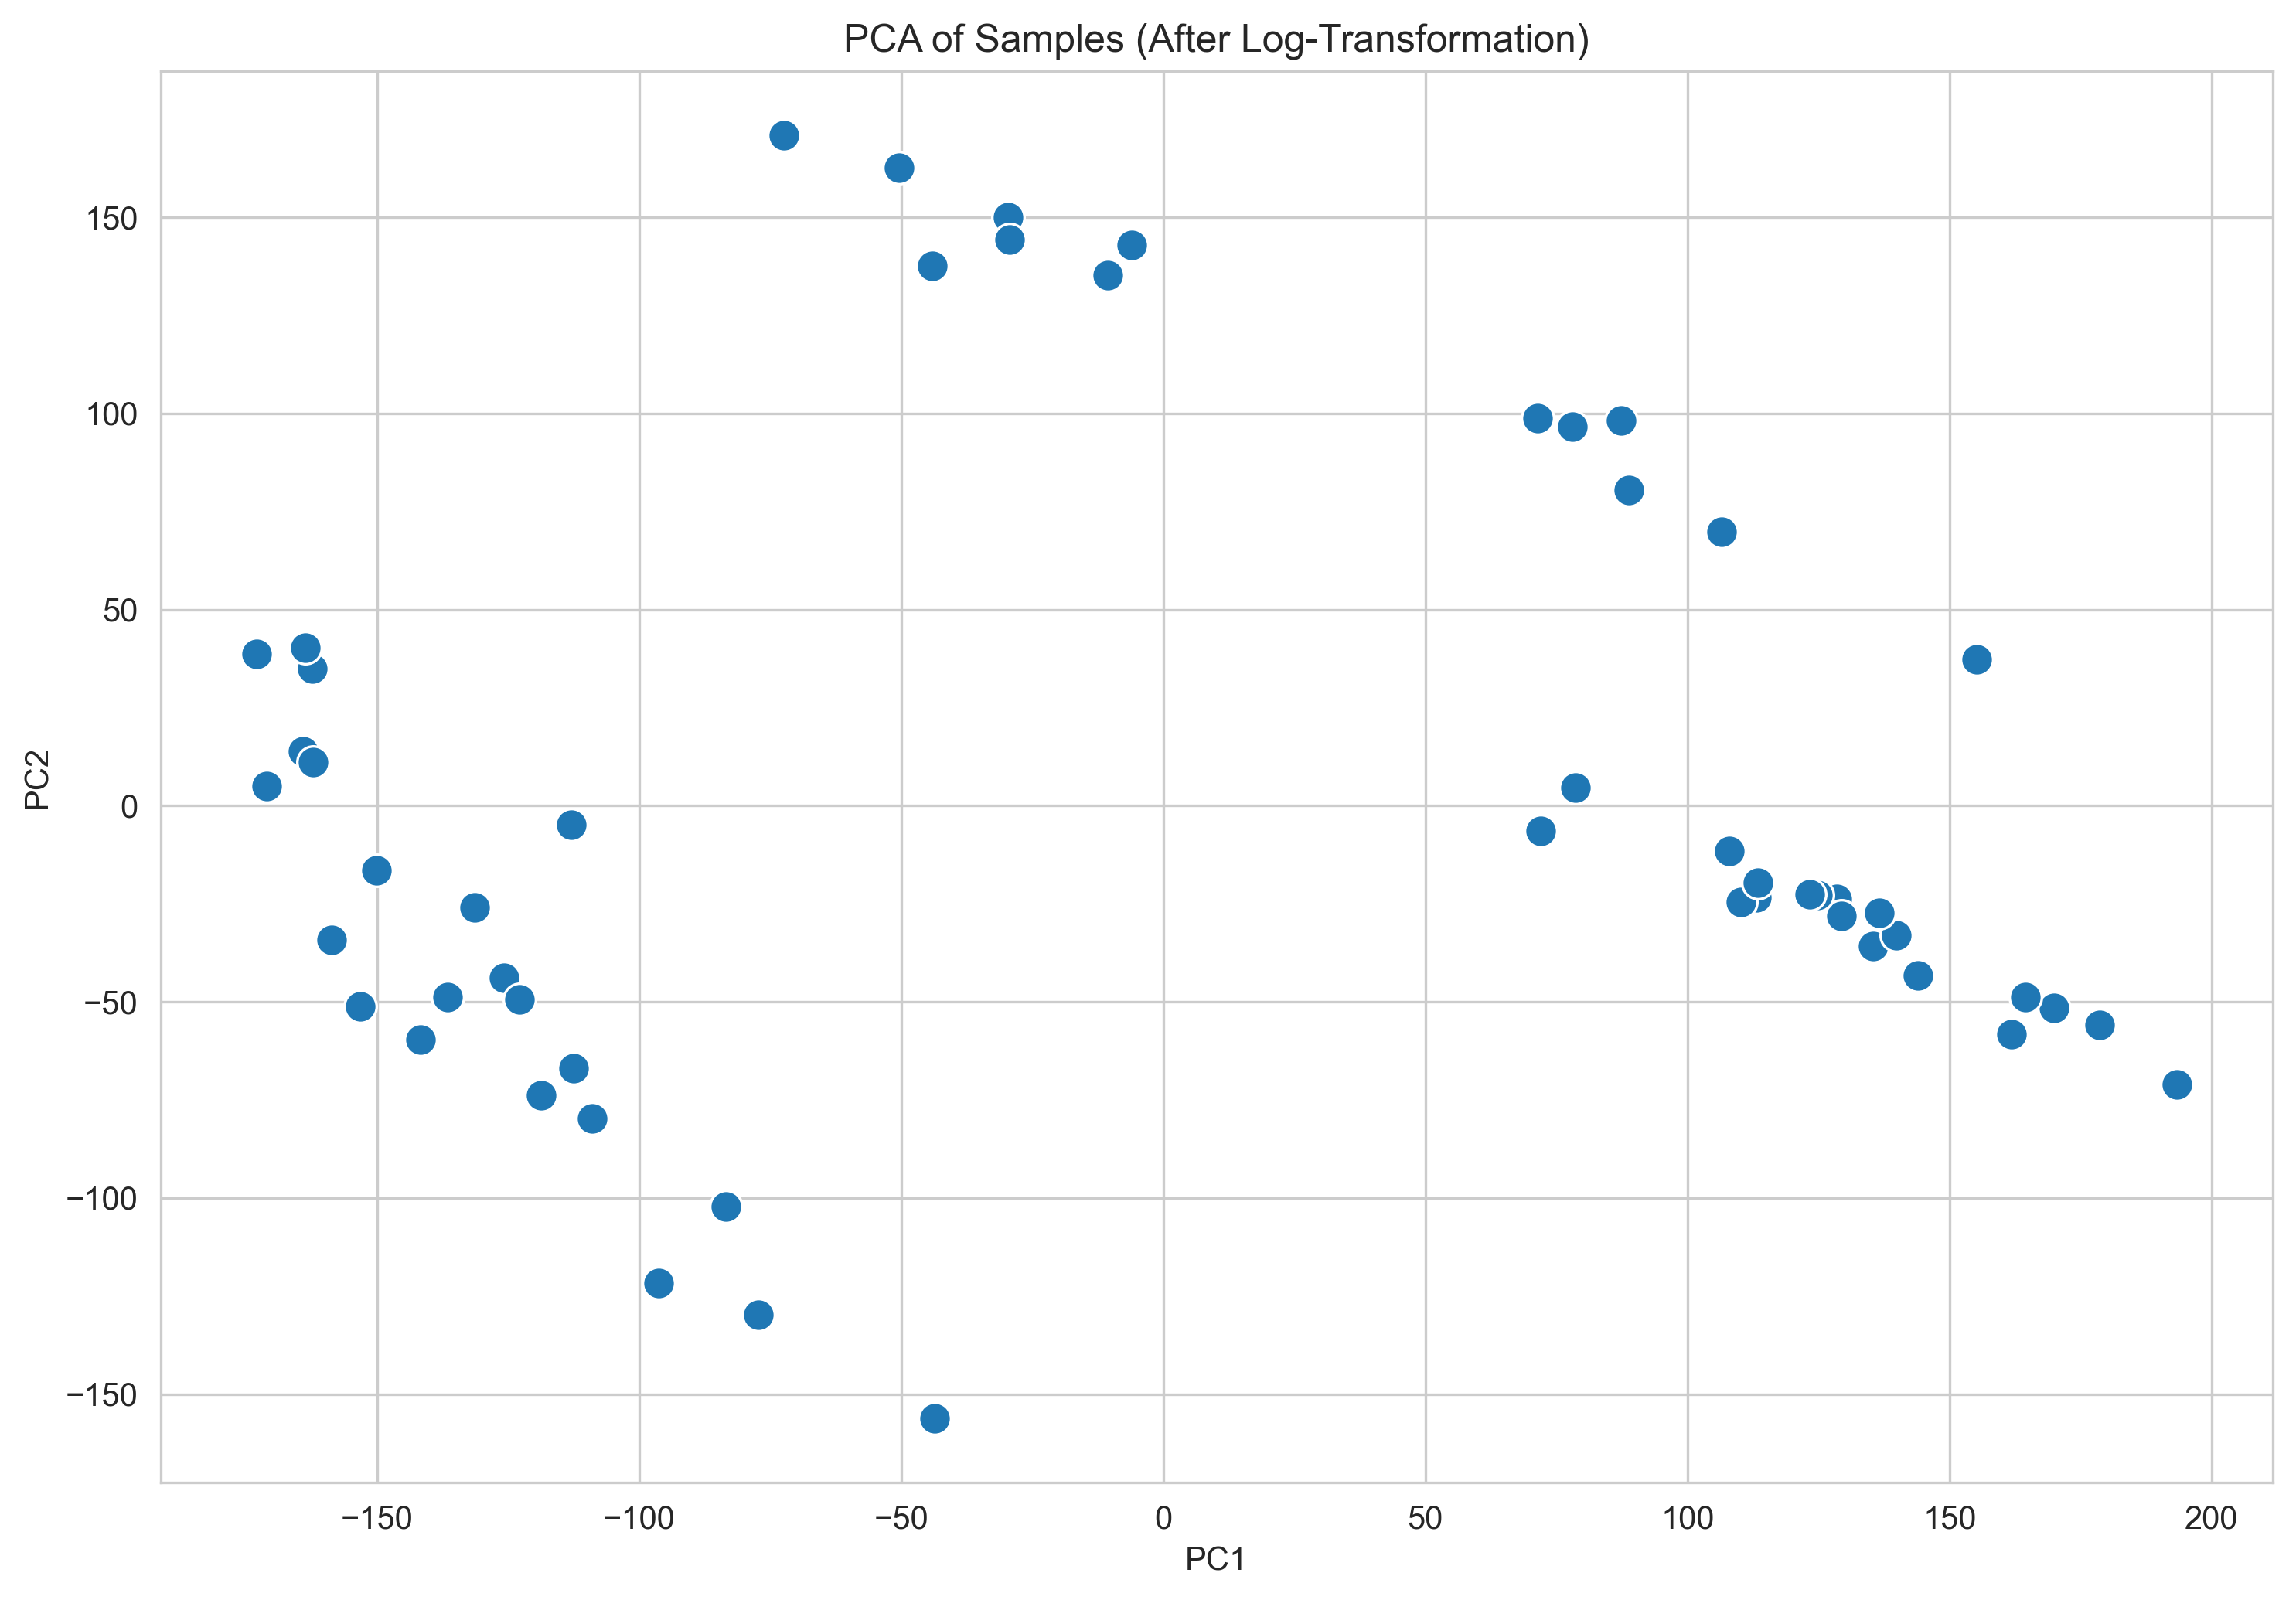

In [14]:
# Calculate the principal components (PCs) of the counts data matrix after log-transformation
matrix_log_transformed = count_matrix_log_transformed.iloc[:, 1:].T
pca = decomposition.PCA(n_components=2)
pca.fit(matrix_log_transformed)
log_transformed_data = pca.transform(matrix_log_transformed)
log_transformed_df = pd.DataFrame(log_transformed_data, index=matrix_log_transformed.index, columns=['PC1', 'PC2'])

# Plot the first two components
pca_plot(log_transformed_df, 'PCA of Samples (After Log-Transformation)', 'pca_after_transformation.png')

After normalization and log2(1+x) transformation, the data clusters are much better segregated. The log2(1+x) transformation is an appropriate pre-processing method for this dataset.

### 1f) Clustering

In [15]:
# Perform PCA with all PCs
components = 54
matrix_clustering = count_matrix_log_transformed.iloc[:, 1:].T
pca = decomposition.PCA(components)
pca.fit(matrix_clustering)
transformed_data_clustering = pca.transform(matrix_clustering)
transformed_df_clustering = pd.DataFrame(transformed_data_clustering, index=matrix_clustering.index, columns=[f'PC{i+1}' for i in range(components)])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

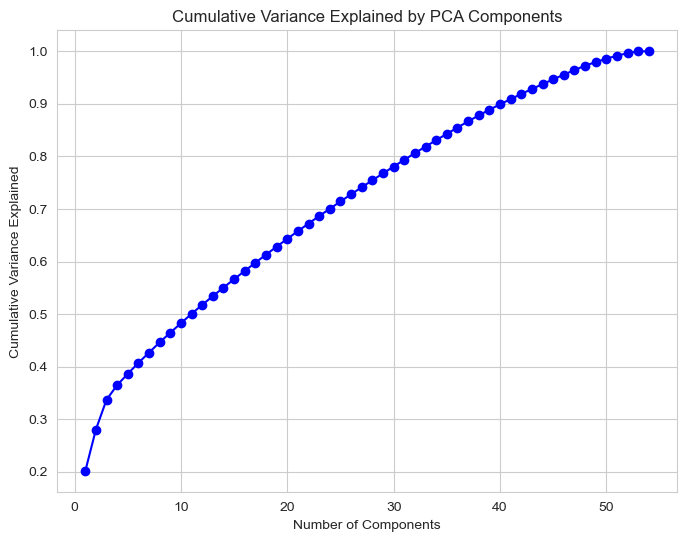

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

In [17]:
# Perform K means clustering on all the PCs
clusters = 3
kmeans = KMeans(n_clusters=clusters, n_init=100).fit(transformed_df_clustering)
cluster_labels = kmeans.labels_
cluster_series = pd.Series(cluster_labels, index=count_matrix_log_transformed.columns[1:])
cluster_series.name = "Cluster Labels"

In [18]:
# Plot the PCA with the clusters labels
transformed_df_cluster = pd.concat([pd.DataFrame(transformed_df_clustering, index=matrix_clustering.index, columns=['PC1', 'PC2']), cluster_series], axis=1)

# Remap clusters, so that the first one is the one with more points
cluster_sizes = transformed_df_cluster['Cluster Labels'].value_counts()
sorted_clusters = cluster_sizes.sort_values(ascending=False).index
cluster_label_map = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
transformed_df_cluster['Cluster Labels'] = transformed_df_cluster['Cluster Labels'].map(cluster_label_map)
cluster_series = cluster_series.map(cluster_label_map)

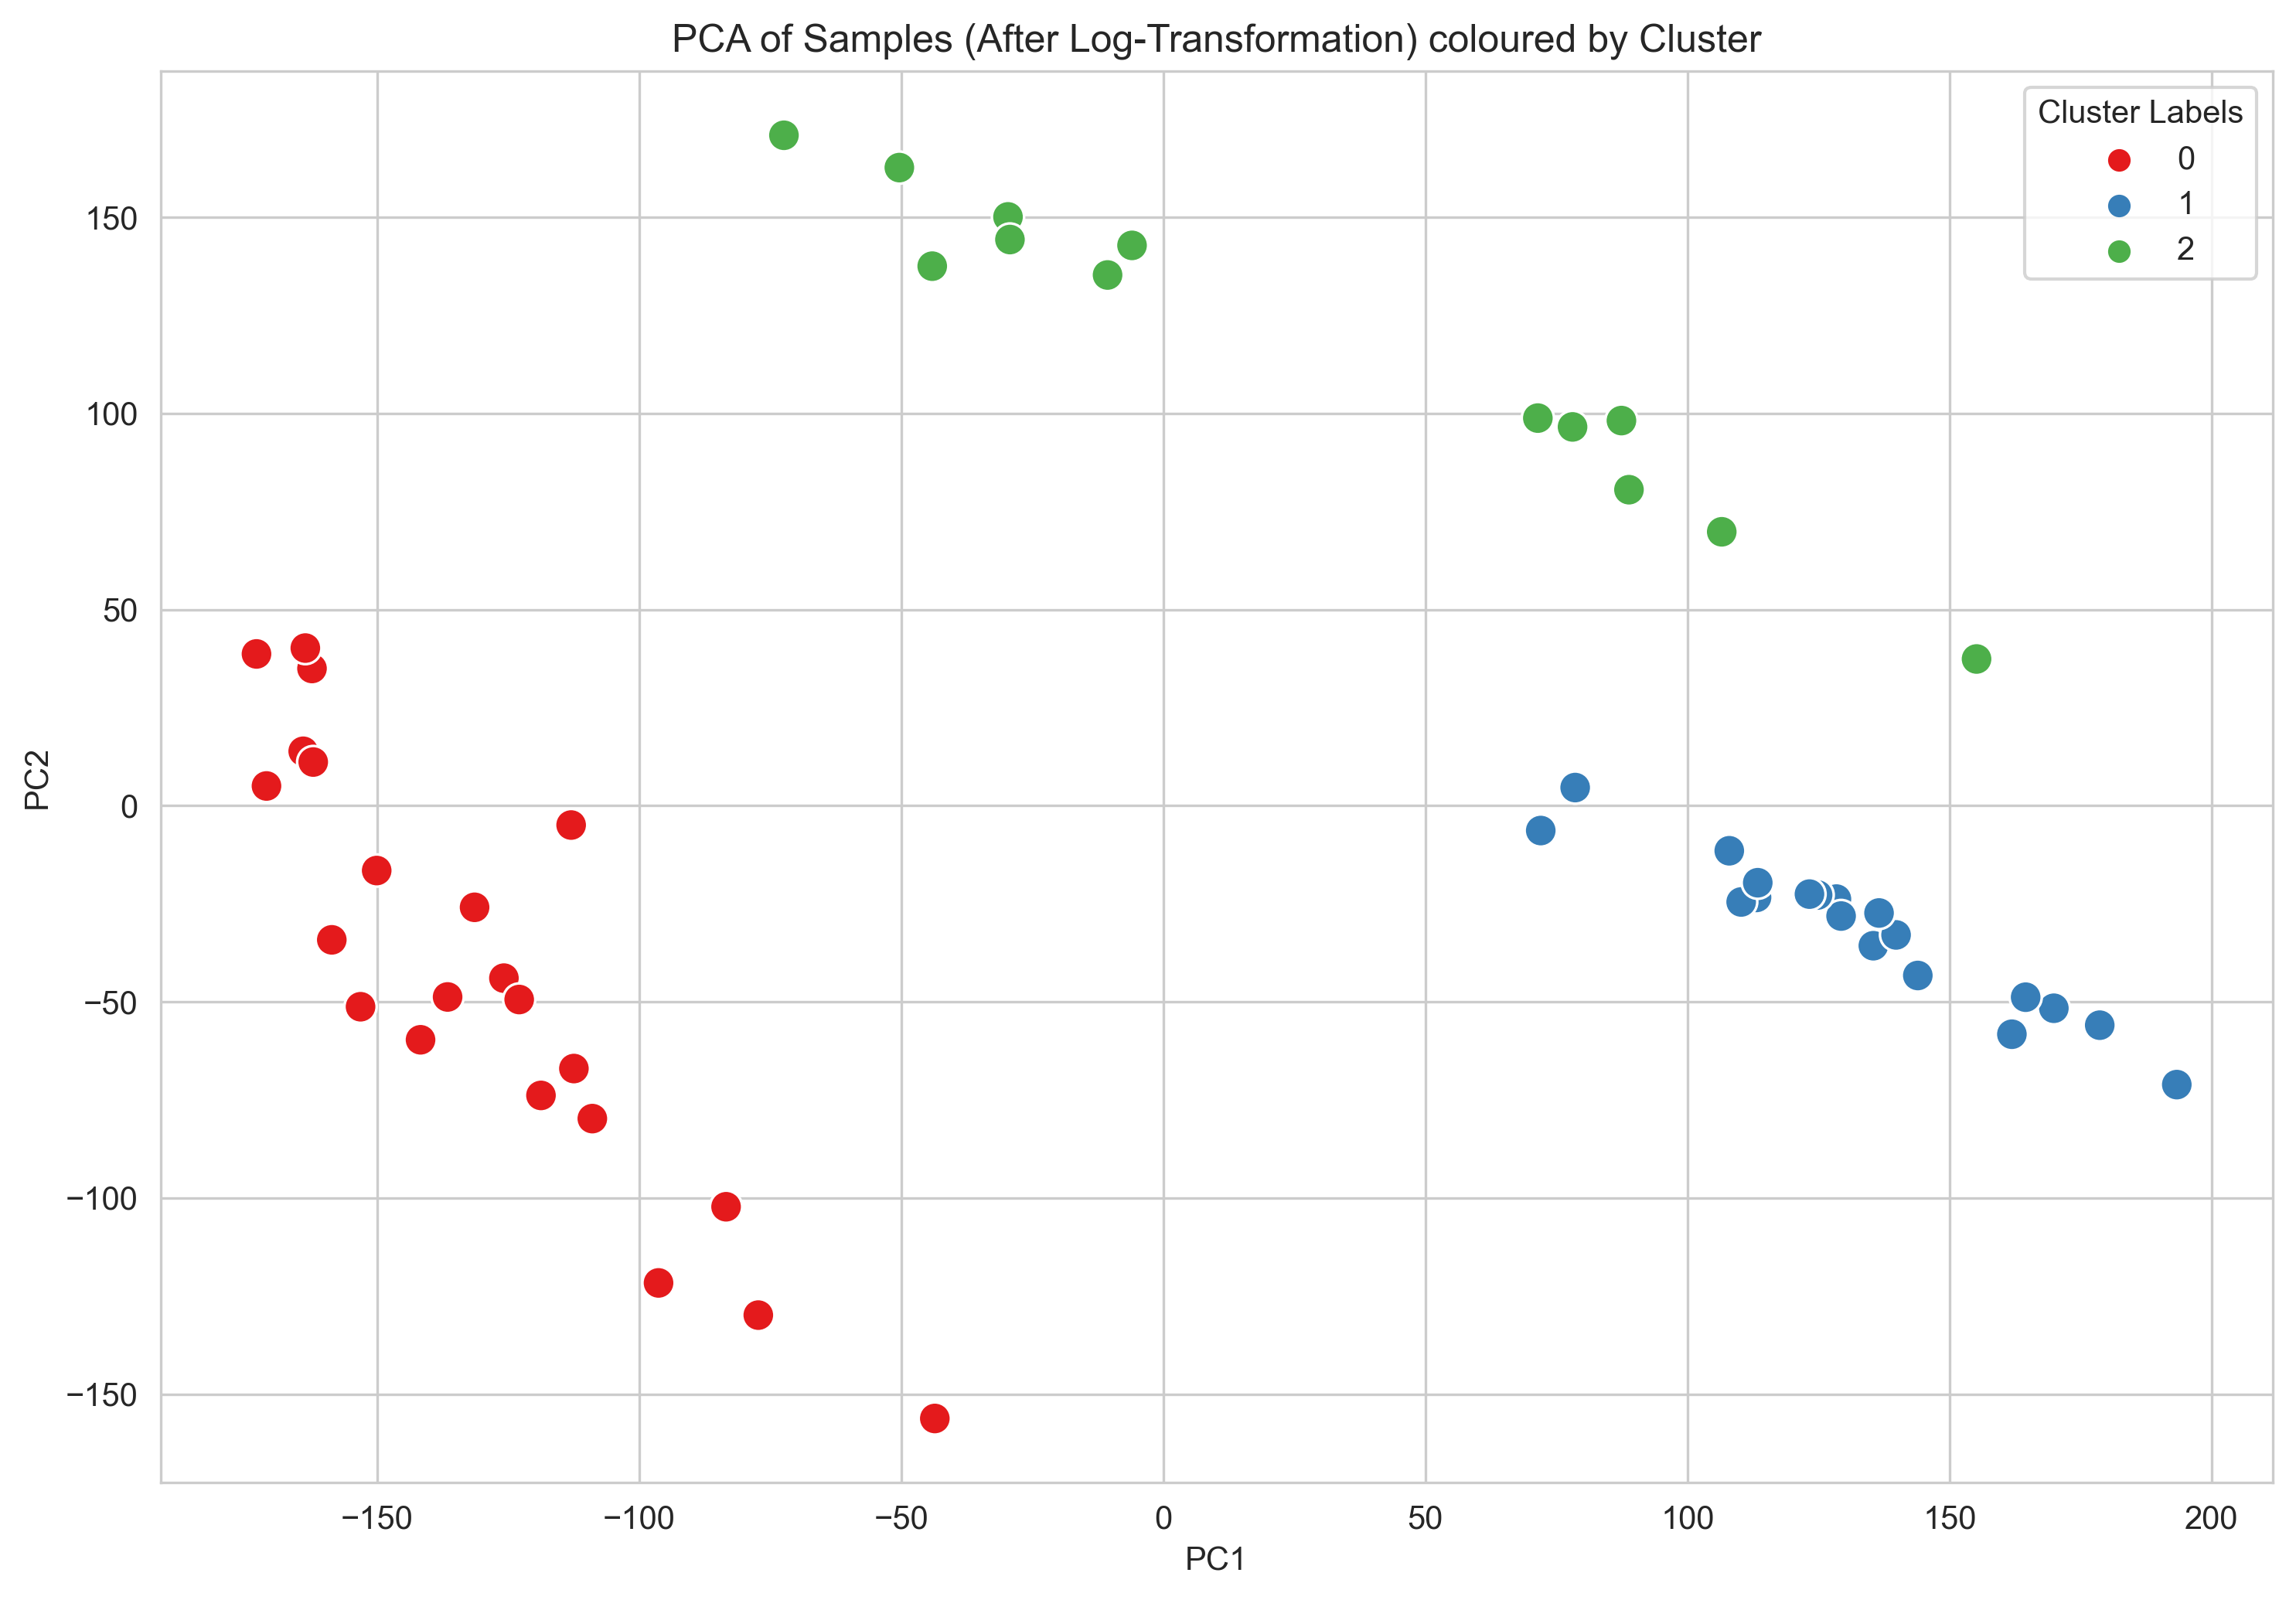

In [19]:
# Plot the first two components
pca_plot(transformed_df_cluster, 'PCA of Samples (After Log-Transformation) coloured by Cluster', 'pca_after_transformation_coloured.png', 'Cluster Labels')

## 2) Differential gene expression 

### 2a) Perform T-tests

In [20]:
# Define a dataframe for each group
df_cluster_1 = pd.DataFrame()
df_cluster_2 = pd.DataFrame()
df_cluster_3 = pd.DataFrame()
df_list = [df_cluster_1, df_cluster_2, df_cluster_3]

In [21]:
# Perform a two-tailed independent t-test on every gene to check if genes are differentially expressed in one cluster when compared to all the other clusters combined. 
data_matrix = count_matrix_log_transformed.iloc[:, 1:]
data_matrix.index = count_matrix_log_transformed['Ensembl IDs']
for i in range(clusters):
    current_samples = cluster_series[cluster_series == i].index
    others_samples = cluster_series[cluster_series != i].index
    t_value, p_value = stats.mannwhitneyu(data_matrix.T.loc[current_samples],  data_matrix.T.loc[others_samples], alternative='two-sided') 
    df_list[i]['p-value'] = p_value
    df_list[i].index = data_matrix.index

In [22]:
# Significant genes
for i in range(clusters):
    print("For the cluster {}, the number of significant genes is {}".format(i + 1, (df_list[i]['p-value'] < 0.05).sum()))

For the cluster 1, the number of significant genes is 7348
For the cluster 2, the number of significant genes is 6723
For the cluster 3, the number of significant genes is 4902


### 2b) FDR correction

In [23]:
# Now, adjust the p-values for multiple testing using the FDR correction (Benjamini-Hochberg) correction, and store the output in the correct column of the pandas Data Frame.
for i in range(clusters):
    result = multipletests(df_list[i]['p-value'], alpha=0.05, method='fdr_bh')
    df_list[i]['fdr'] = result[1]


We need this correction because when we perform multiple hypothesis tests on the same dataset, the likelihood of obtaining at least one false positive increases.

### 2c) Means

In [24]:
for i in range(clusters):
    current_samples = cluster_series[cluster_series == i].index
    others_samples = cluster_series[cluster_series != i].index
    df_list[i]['mean'] = data_matrix[current_samples].mean(axis=1)
    df_list[i]['mean_other'] = data_matrix[others_samples].mean(axis=1)


### 2d) Fold change

In [25]:
for i in range(clusters):
    df_list[i]['log2_fold_change'] = np.log2(1 + df_list[i]['mean']) - np.log2(1 + df_list[i]['mean_other'])

### 2e) Filtering of upregulated genes

In [26]:
df_filtered_list = []
# Filter the pandas Data Frame and keep only upregulated genes that have FDR < 5% and fold change > 2 (log2_fold change>1). Sort by decreasing fold change. 
for i in range(clusters):
    filtered_df = df_list[i][(df_list[i]['fdr'] < 0.05) & (df_list[i]['log2_fold_change'] > 1)]
    df_filtered_list.append(filtered_df.sort_values(by='log2_fold_change', ascending=False))

### 2f) Volcano Plot

In [27]:
def volcano_plot(df_cluster_filtered, fdr_threshold, fc_threshold, title, name):
    df_cluster_filtered['-log10(FDR)'] = -np.log10(df_cluster_filtered['fdr'])

    df_cluster_filtered['significance'] = 'Not Significant'
    df_cluster_filtered.loc[(df_cluster_filtered['log2_fold_change'] > fc_threshold) & (df_cluster_filtered['fdr'] < fdr_threshold), 'significance'] = 'Upregulated'
    df_cluster_filtered.loc[(df_cluster_filtered['log2_fold_change'] < -fc_threshold) & (df_cluster_filtered['fdr'] < fdr_threshold), 'significance'] = 'Downregulated'
    
    # Plotting
    plt.figure(figsize=(10, 8), dpi=300)
    
    # Scatter plot of all genes
    sns.scatterplot(data=df_cluster_filtered, x='log2_fold_change', y='-log10(FDR)', hue='significance', palette={'Not Significant': 'grey', 'Upregulated': 'red', 'Downregulated': 'blue'}, alpha=0.7, s=60)
    
    # Add fold change and FDR threshold lines
    plt.axvline(x=fc_threshold, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-fc_threshold, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=-np.log10(fdr_threshold), color='black', linestyle='--', linewidth=1)
    
    # Add labels
    plt.title(title, fontsize=16)
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-Log10(FDR)', fontsize=12)
    
    # Display the plot
    plt.legend(title='Gene Significance', loc='upper right')
    plt.tight_layout()
    plt.savefig('figures/{}.png'.format(name), format="png", dpi=300)  
    plt.show()

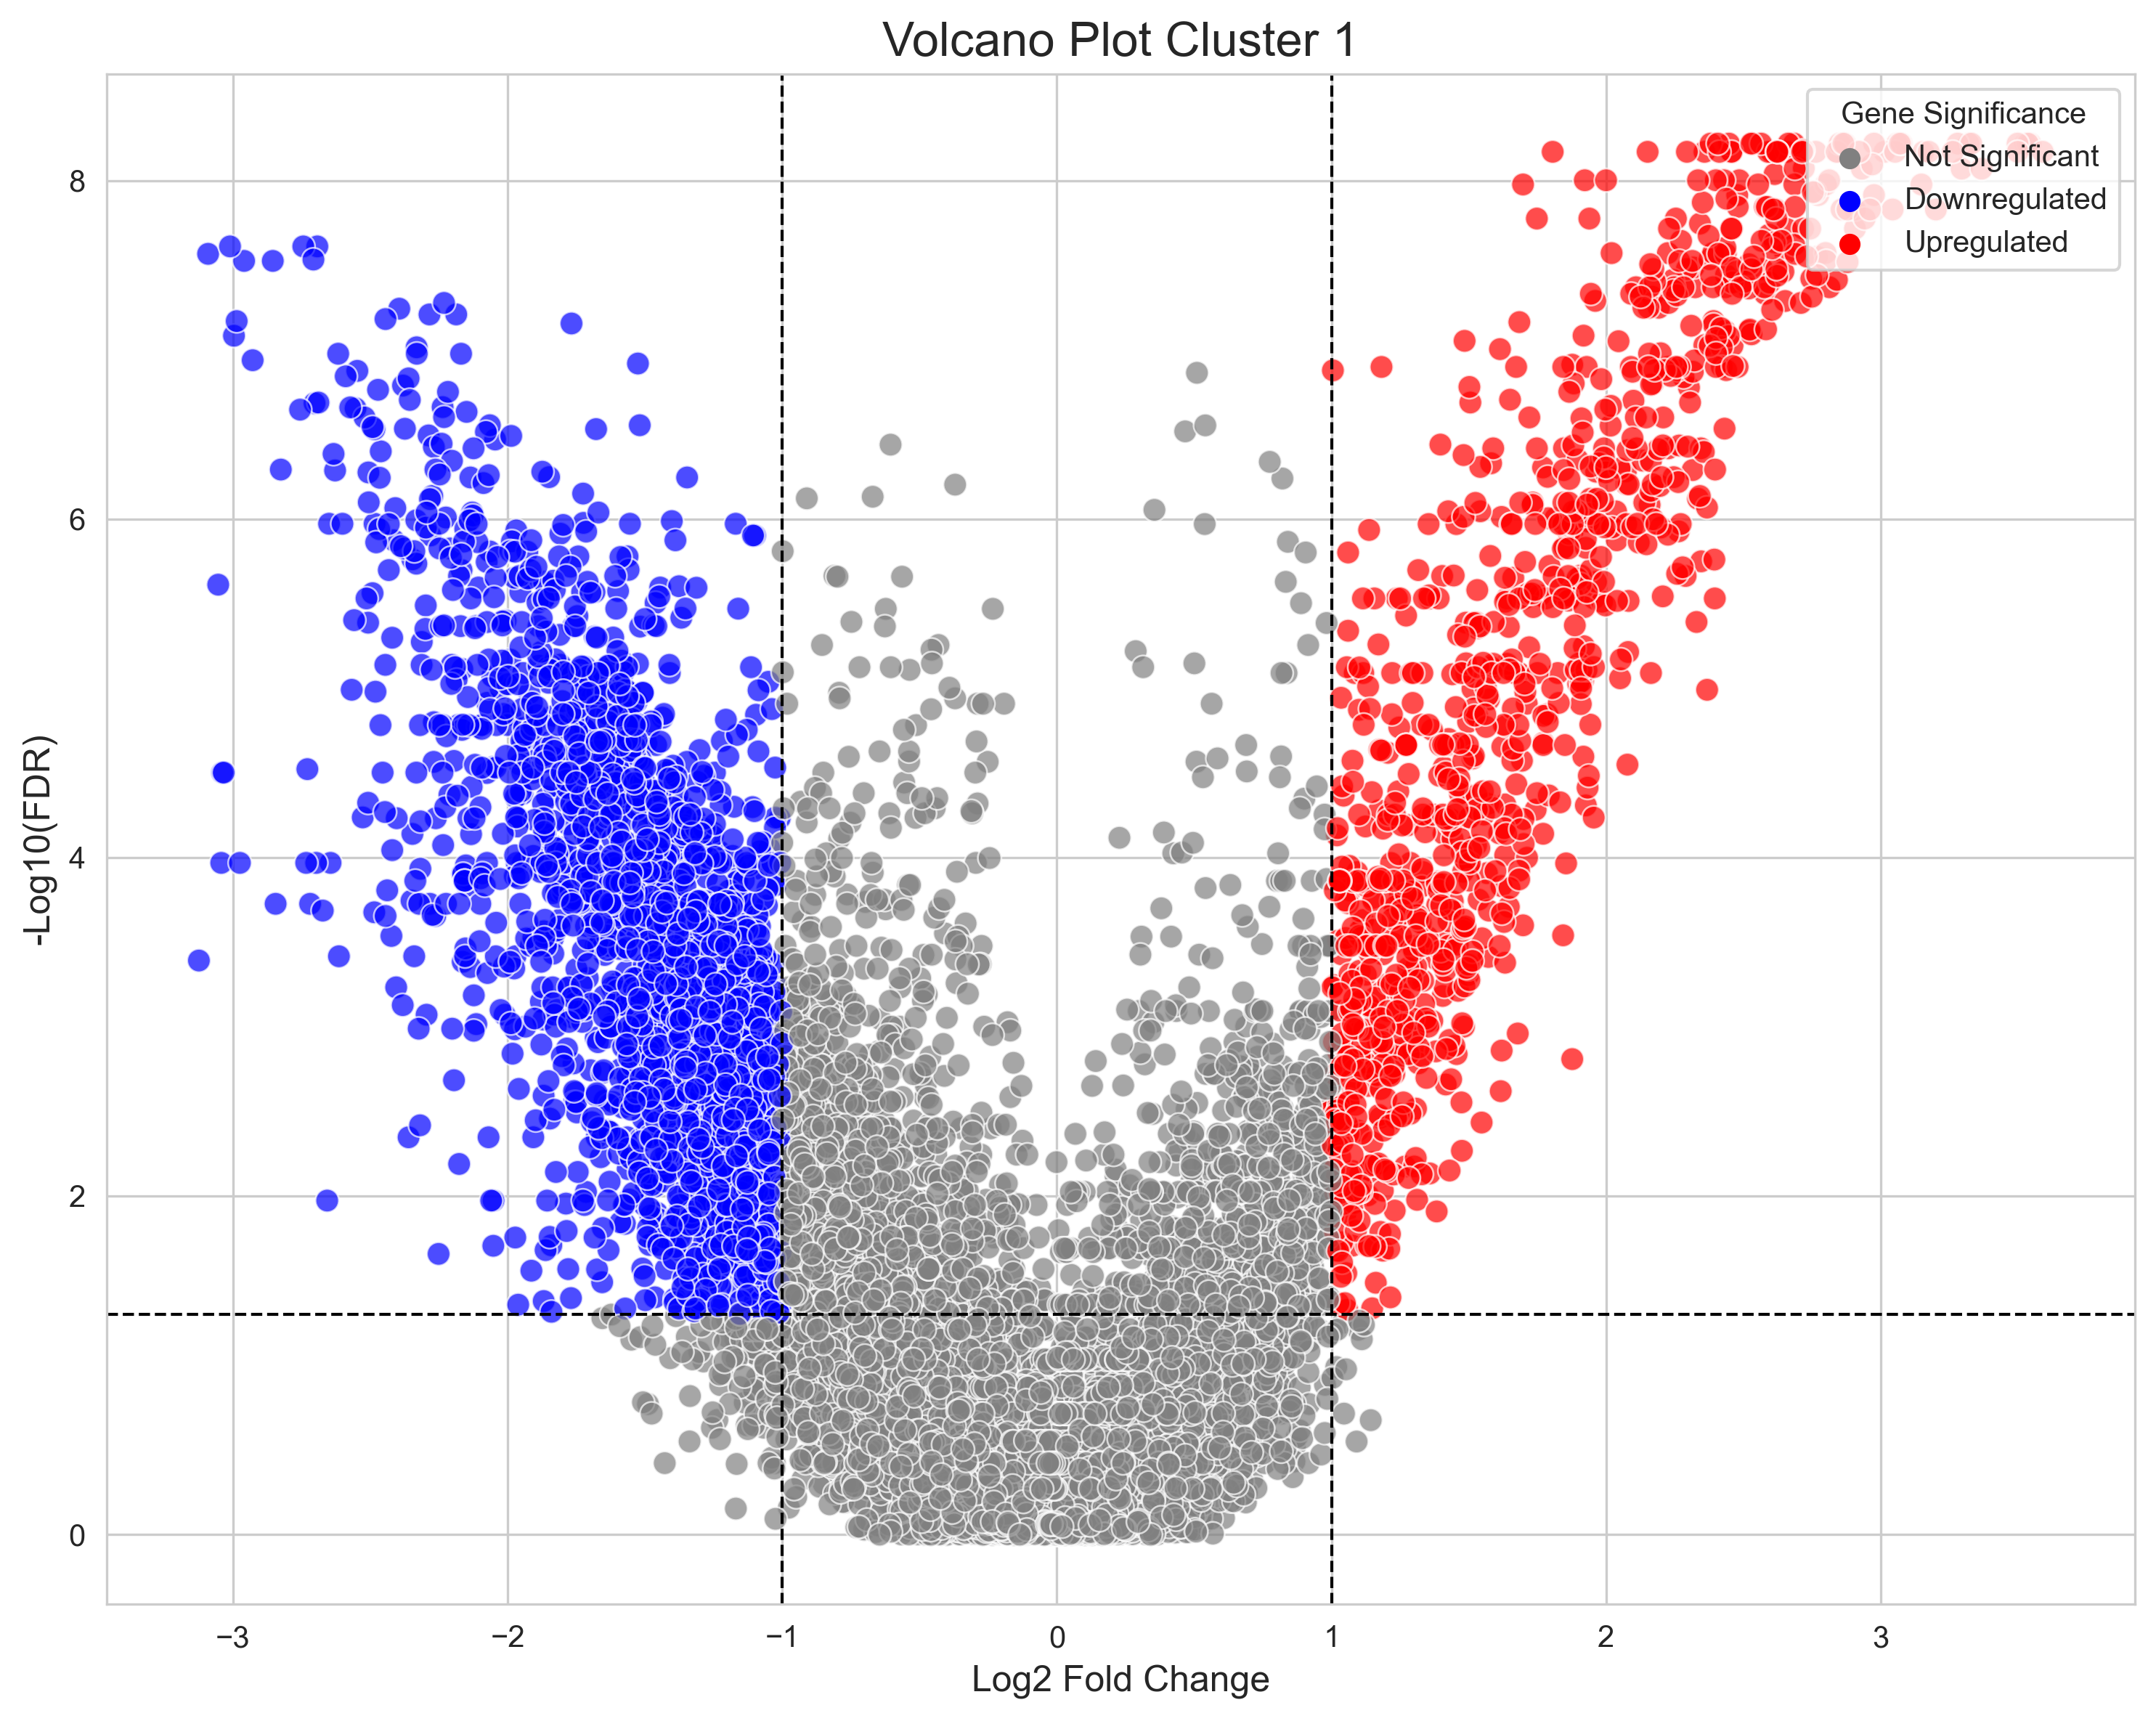

In [28]:
fc_threshold = 1
fdr_threshold = 0.05

volcano_plot(df_list[0], fdr_threshold, fc_threshold, title='Volcano Plot Cluster 1', name='volcano_plot_cluster_1')

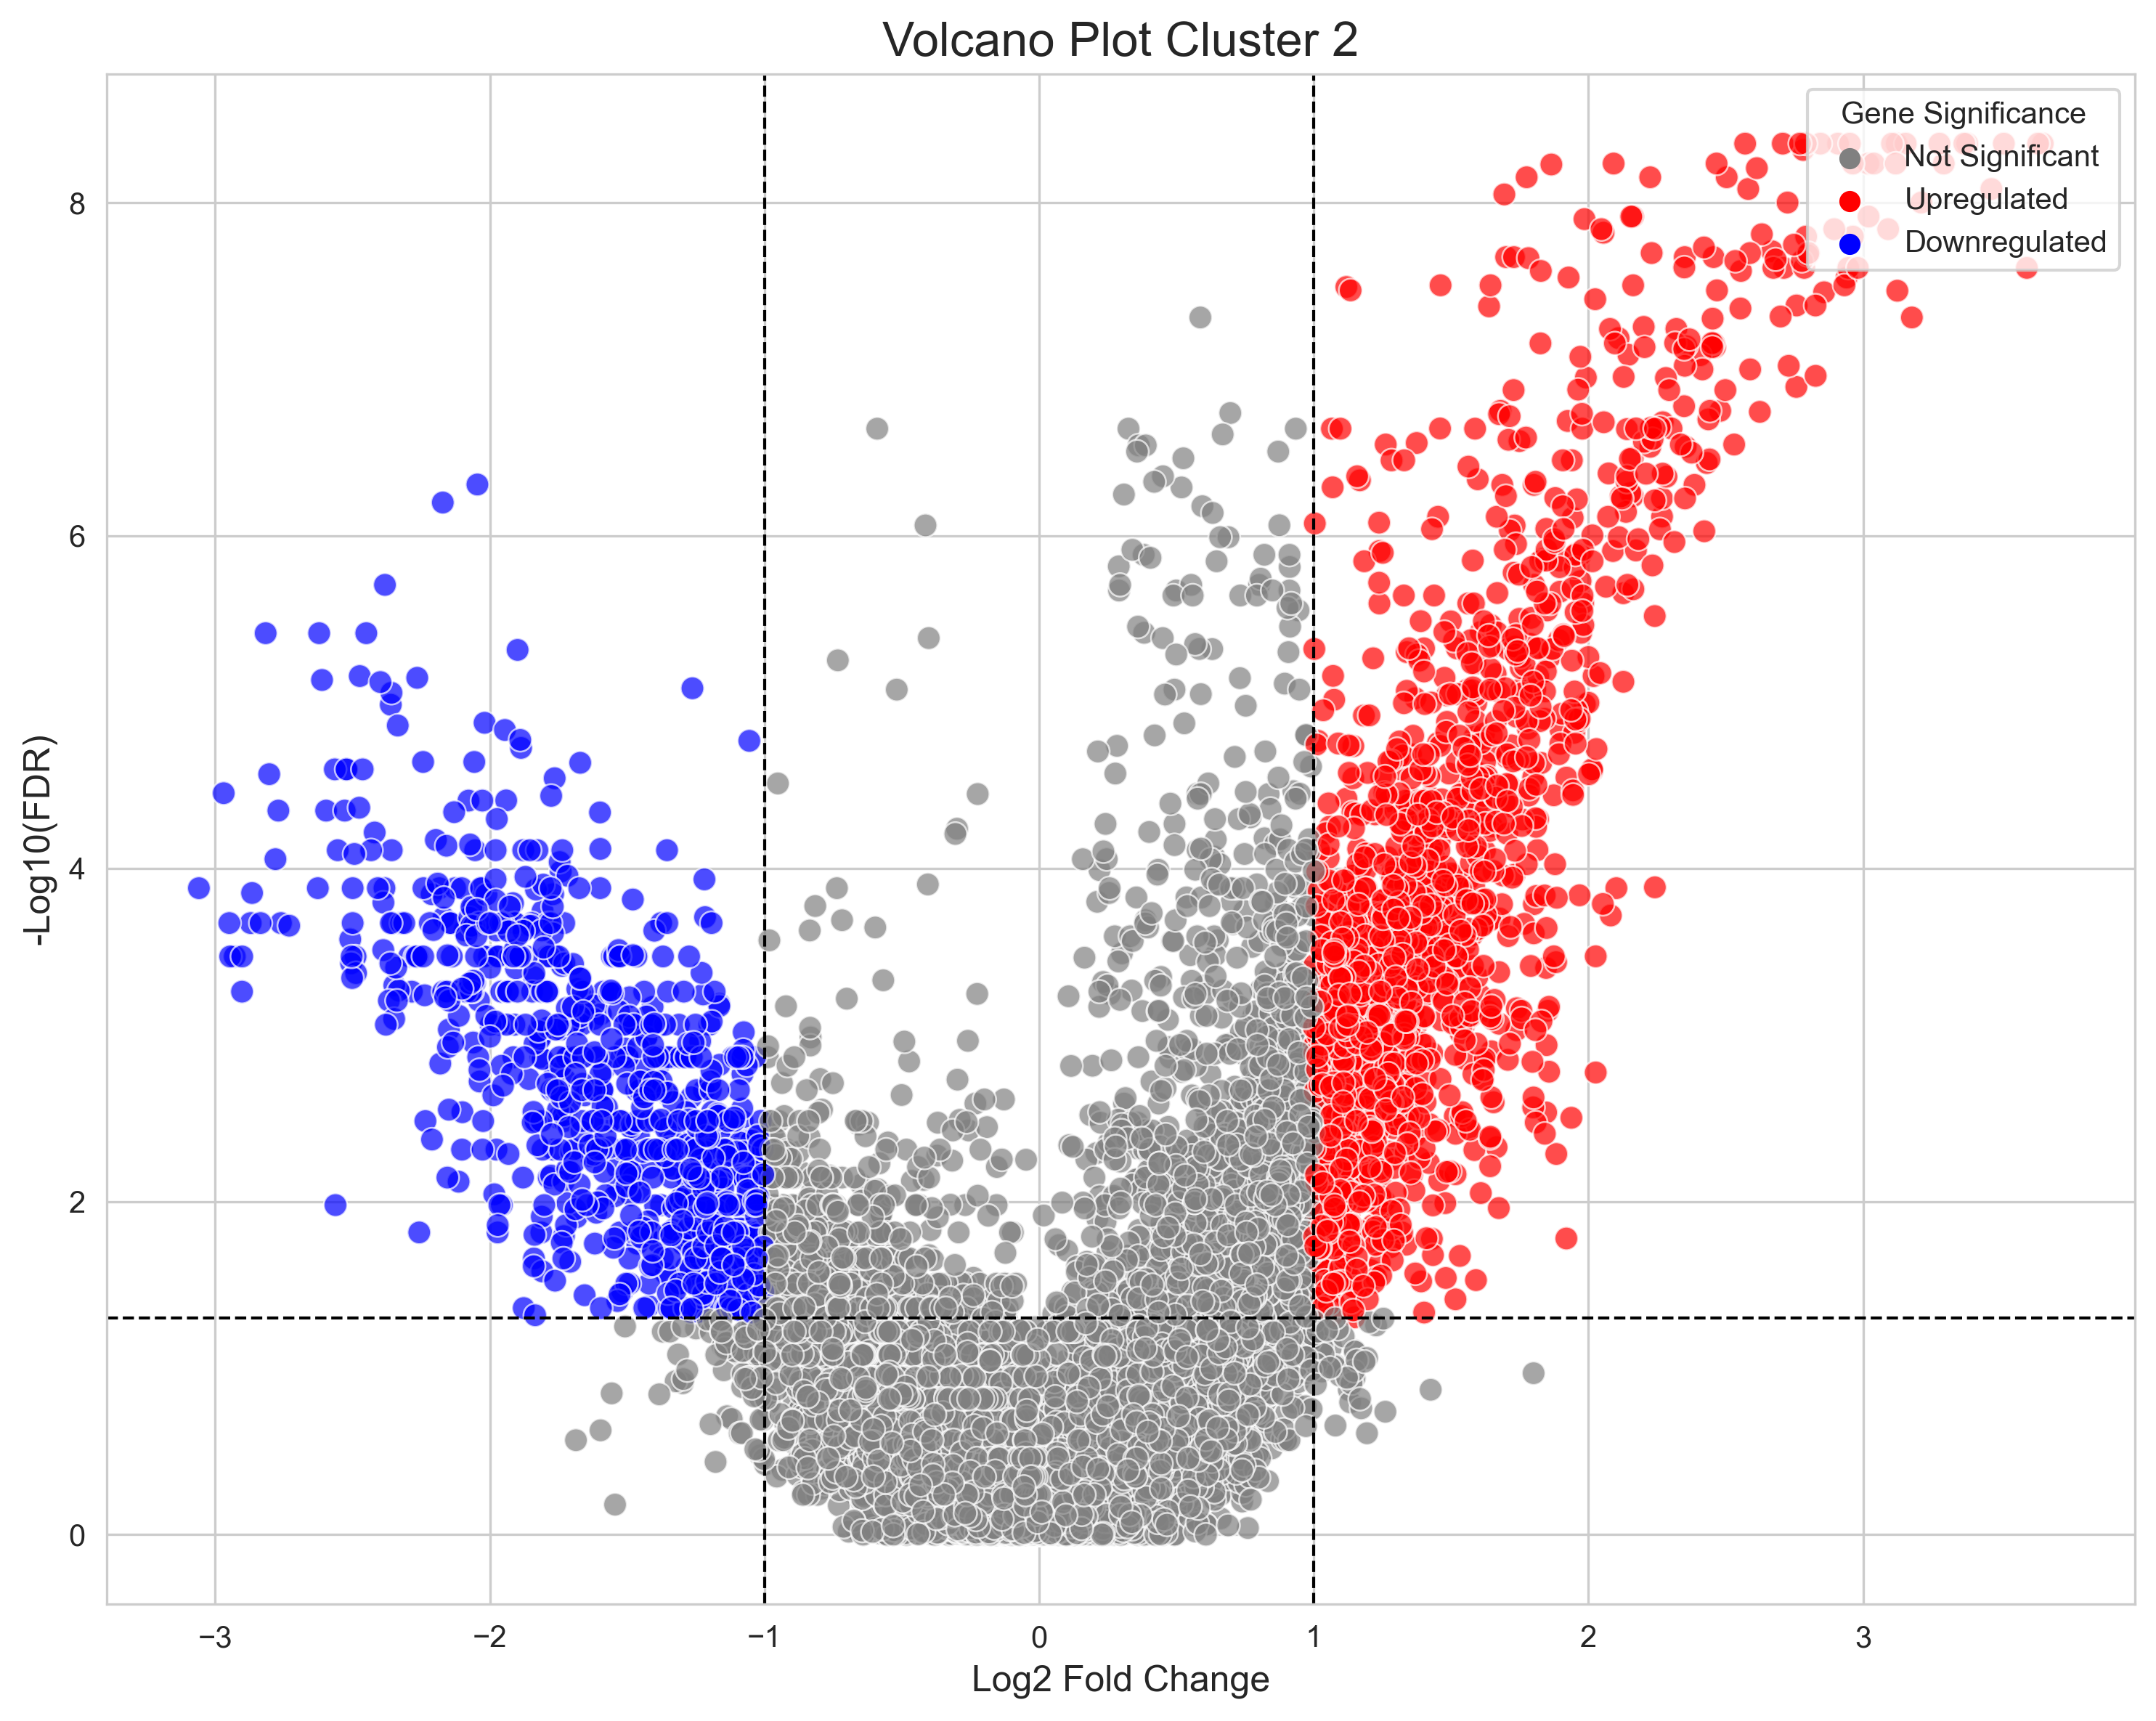

In [29]:
volcano_plot(df_list[1], fdr_threshold, fc_threshold, title='Volcano Plot Cluster 2', name='volcano_plot_cluster_2')

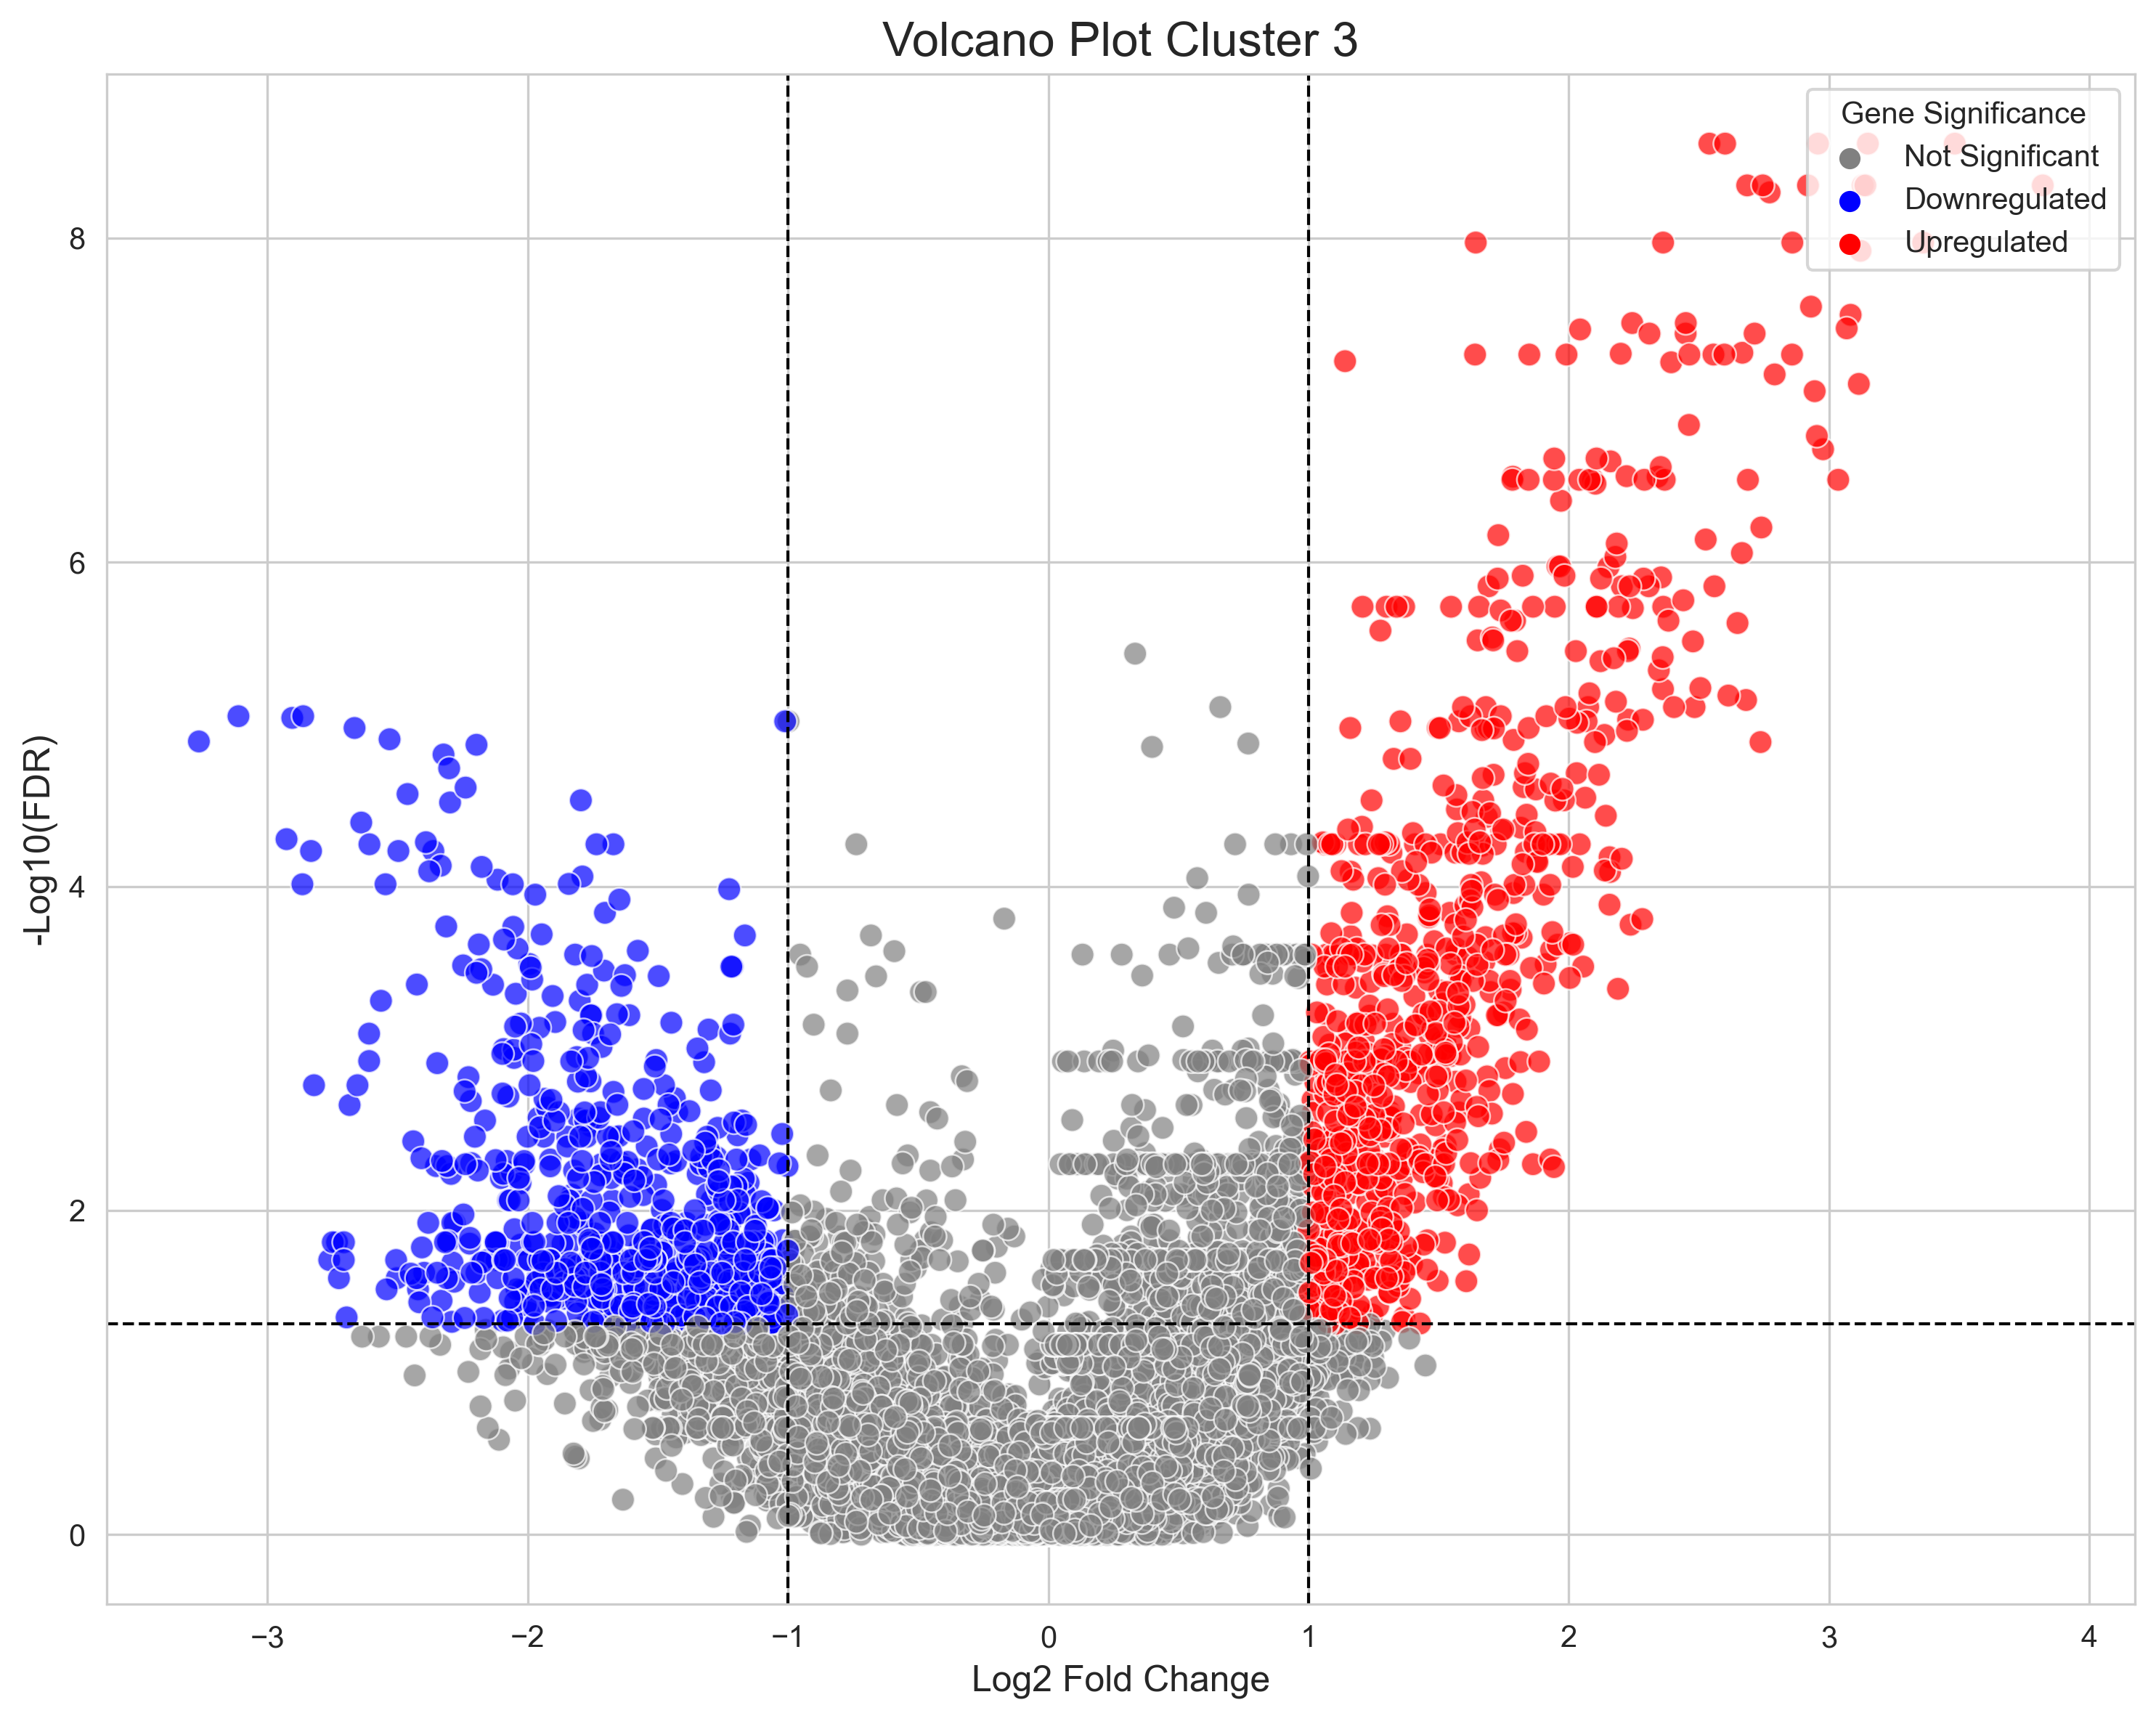

In [30]:
volcano_plot(df_list[2], fdr_threshold, fc_threshold, title='Volcano Plot Cluster 3', name='volcano_plot_cluster_3')

## 3) Investigating top marker genes 

### 3a) Gene names

In [31]:
# Read gene_name.txt
gene_names_path = "data/gene_name.txt"
gene_names_df = pd.read_csv(gene_names_path, sep='\t')

In [32]:
for i in range(clusters):
    df_list[i] = pd.merge(df_list[i], gene_names_df, left_on="Ensembl IDs", right_on="Ensembl IDs")

### 3b) Top marker genes

In [33]:
# Find top marker genes for each group: top marker genes are the differentially expressed genes with the highest fold-change.
top_genes = []

for i in range(clusters):
    top_gene = df_list[i][df_list[i]['fdr'] < fdr_threshold].sort_values(by='log2_fold_change', ascending=False).iloc[0]['gene_name']
    print("The top gene for cluster {} is {}".format(i + 1, top_gene))
    top_genes.append(top_gene)

The top gene for cluster 1 is TPH2
The top gene for cluster 2 is MYL2
The top gene for cluster 3 is FABP4


In [34]:
def boxplot_gene_name(clusters, top_gene, ensemble_id, cluster_series, data_matrix):
    plot_data = []
    for j in range(clusters):
        current_samples = cluster_series[cluster_series == j].index
        data = data_matrix.T.loc[current_samples, ensemble_id]
        plot_data.append(pd.DataFrame({'Cluster': [f'Cluster {j + 1}'] * len(data), 'Expression': data}))
    
    combined_data = pd.concat(plot_data, ignore_index=True)
    plt.figure(figsize=(10, 6), dpi=300)
    sns.boxplot(x='Cluster', y='Expression', data=combined_data)
    plt.title(f'Box Plot for {top_gene}', fontsize=16)
    plt.xlabel('Clusters')
    plt.ylabel('Gene Expression')
    plt.tight_layout()
    plt.savefig(f'figures/boxplot_gene_{top_gene}.png', format="png", dpi=300)  
    plt.show()

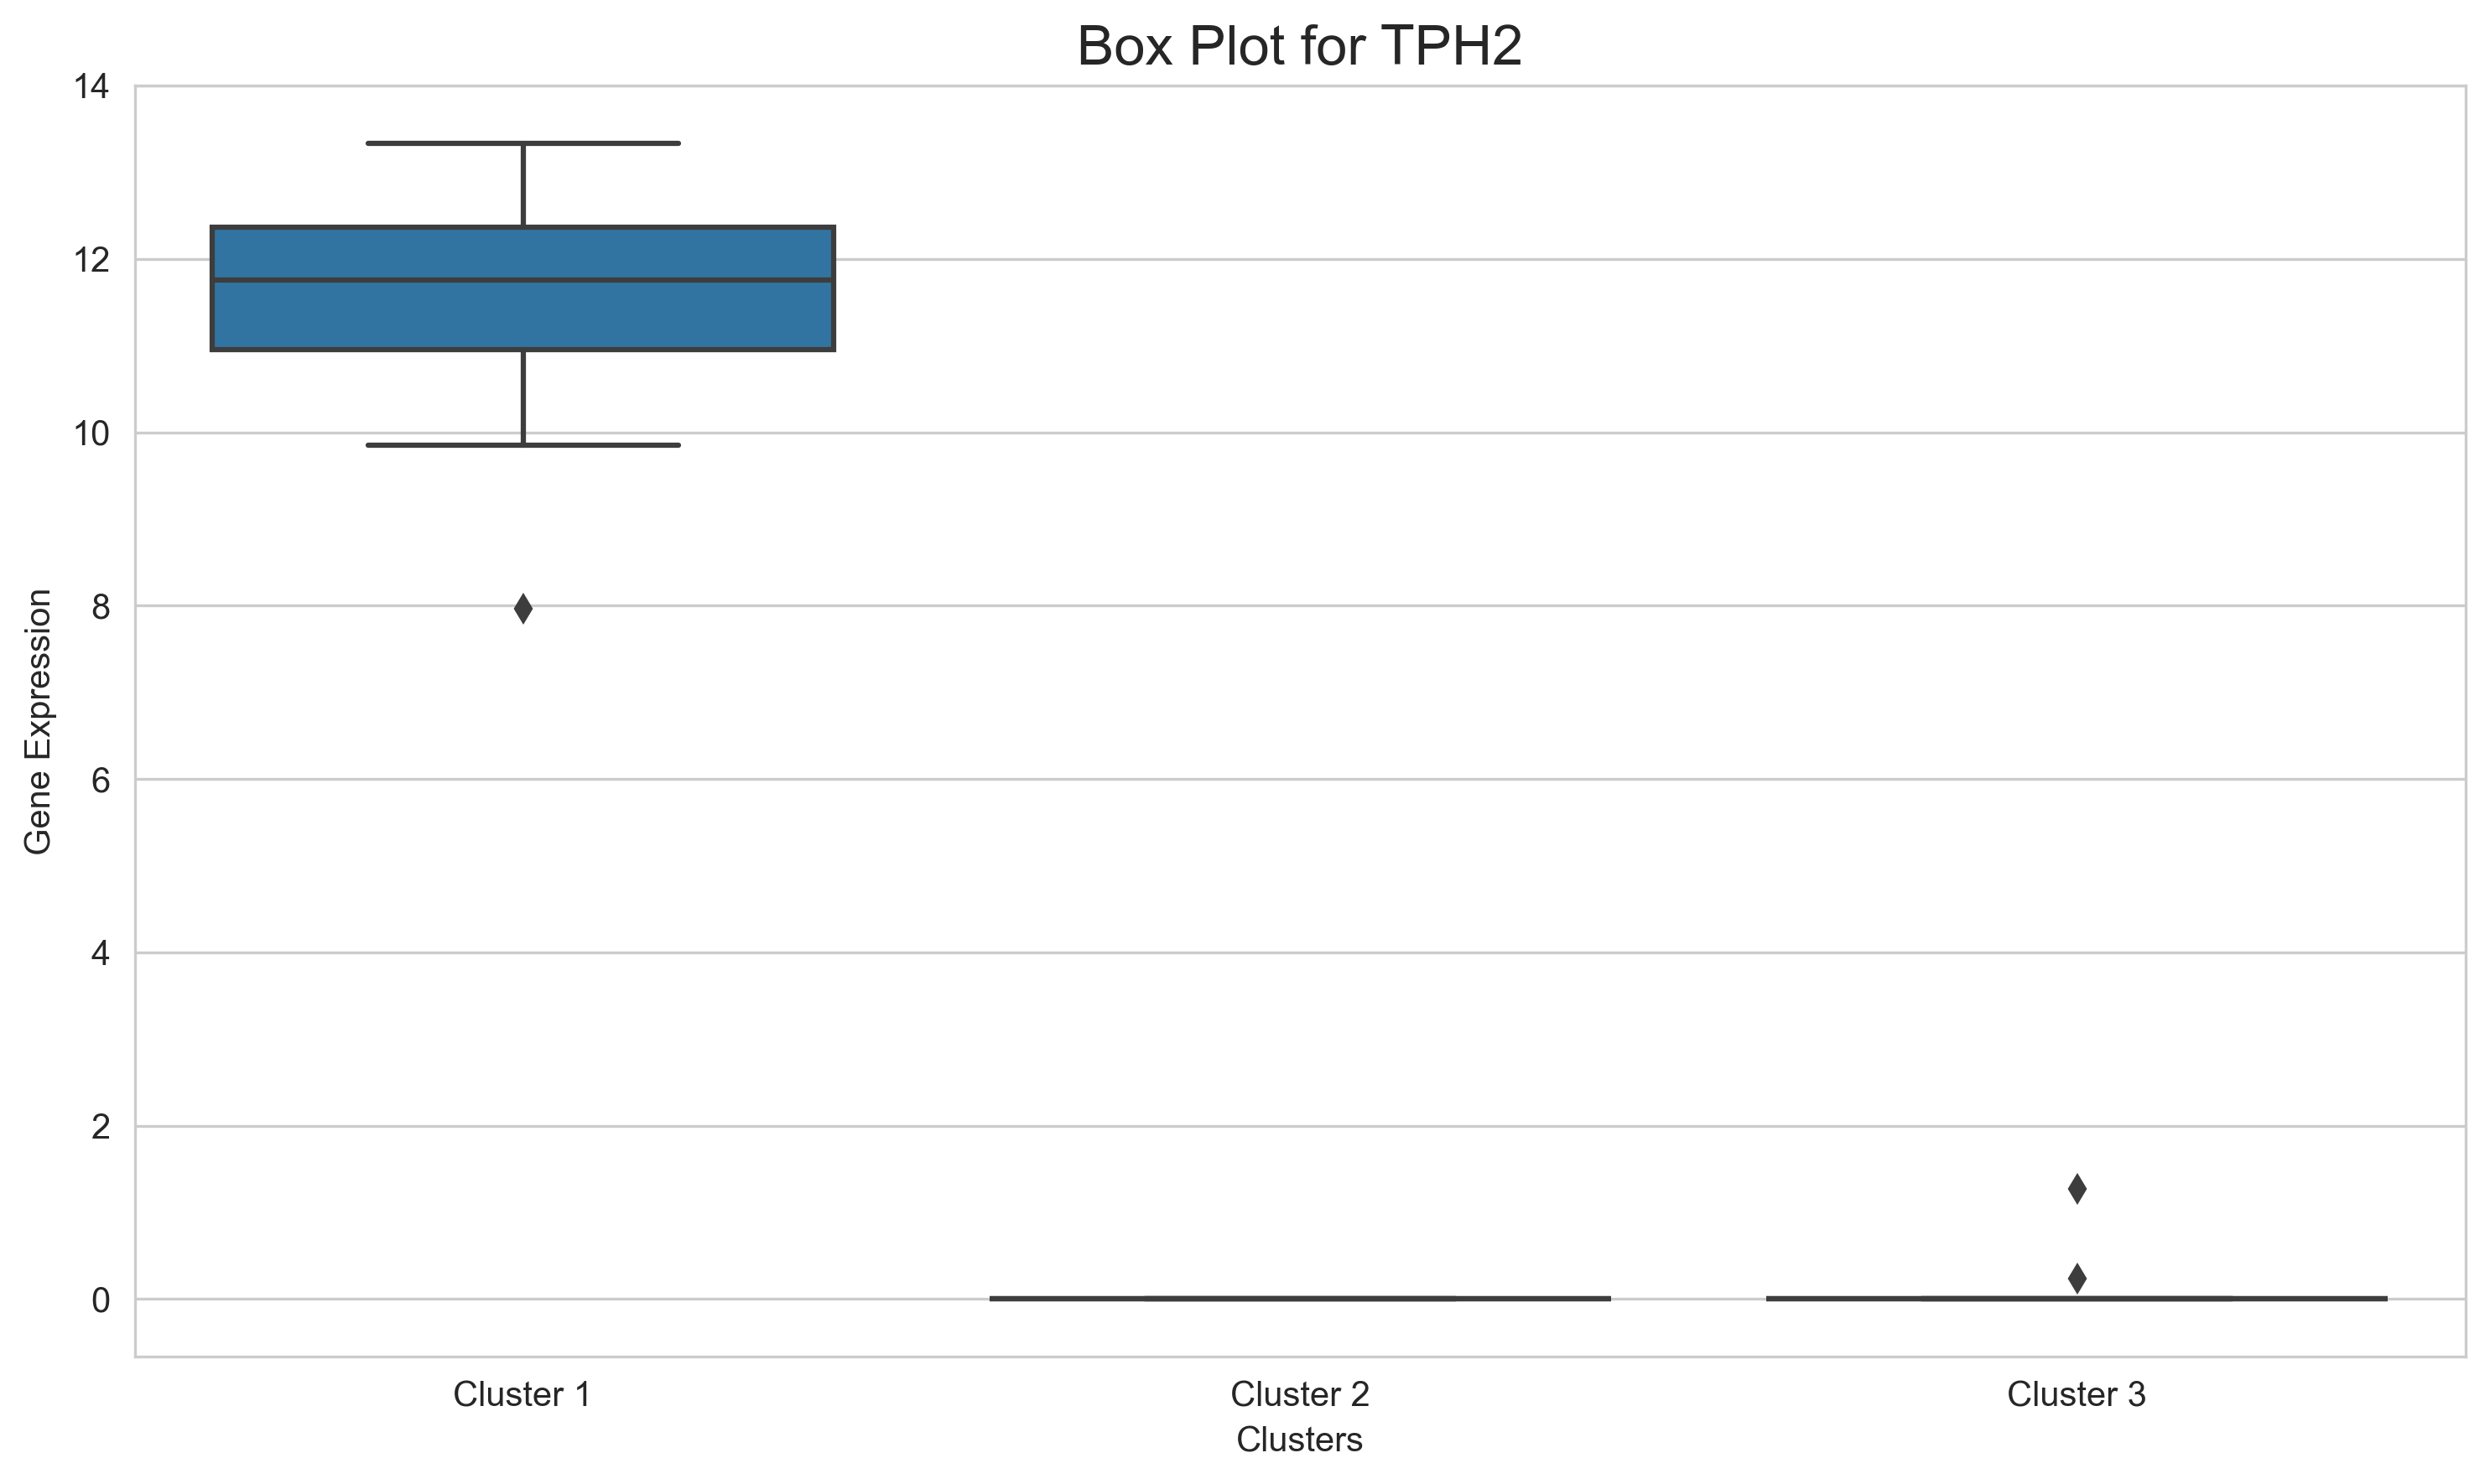

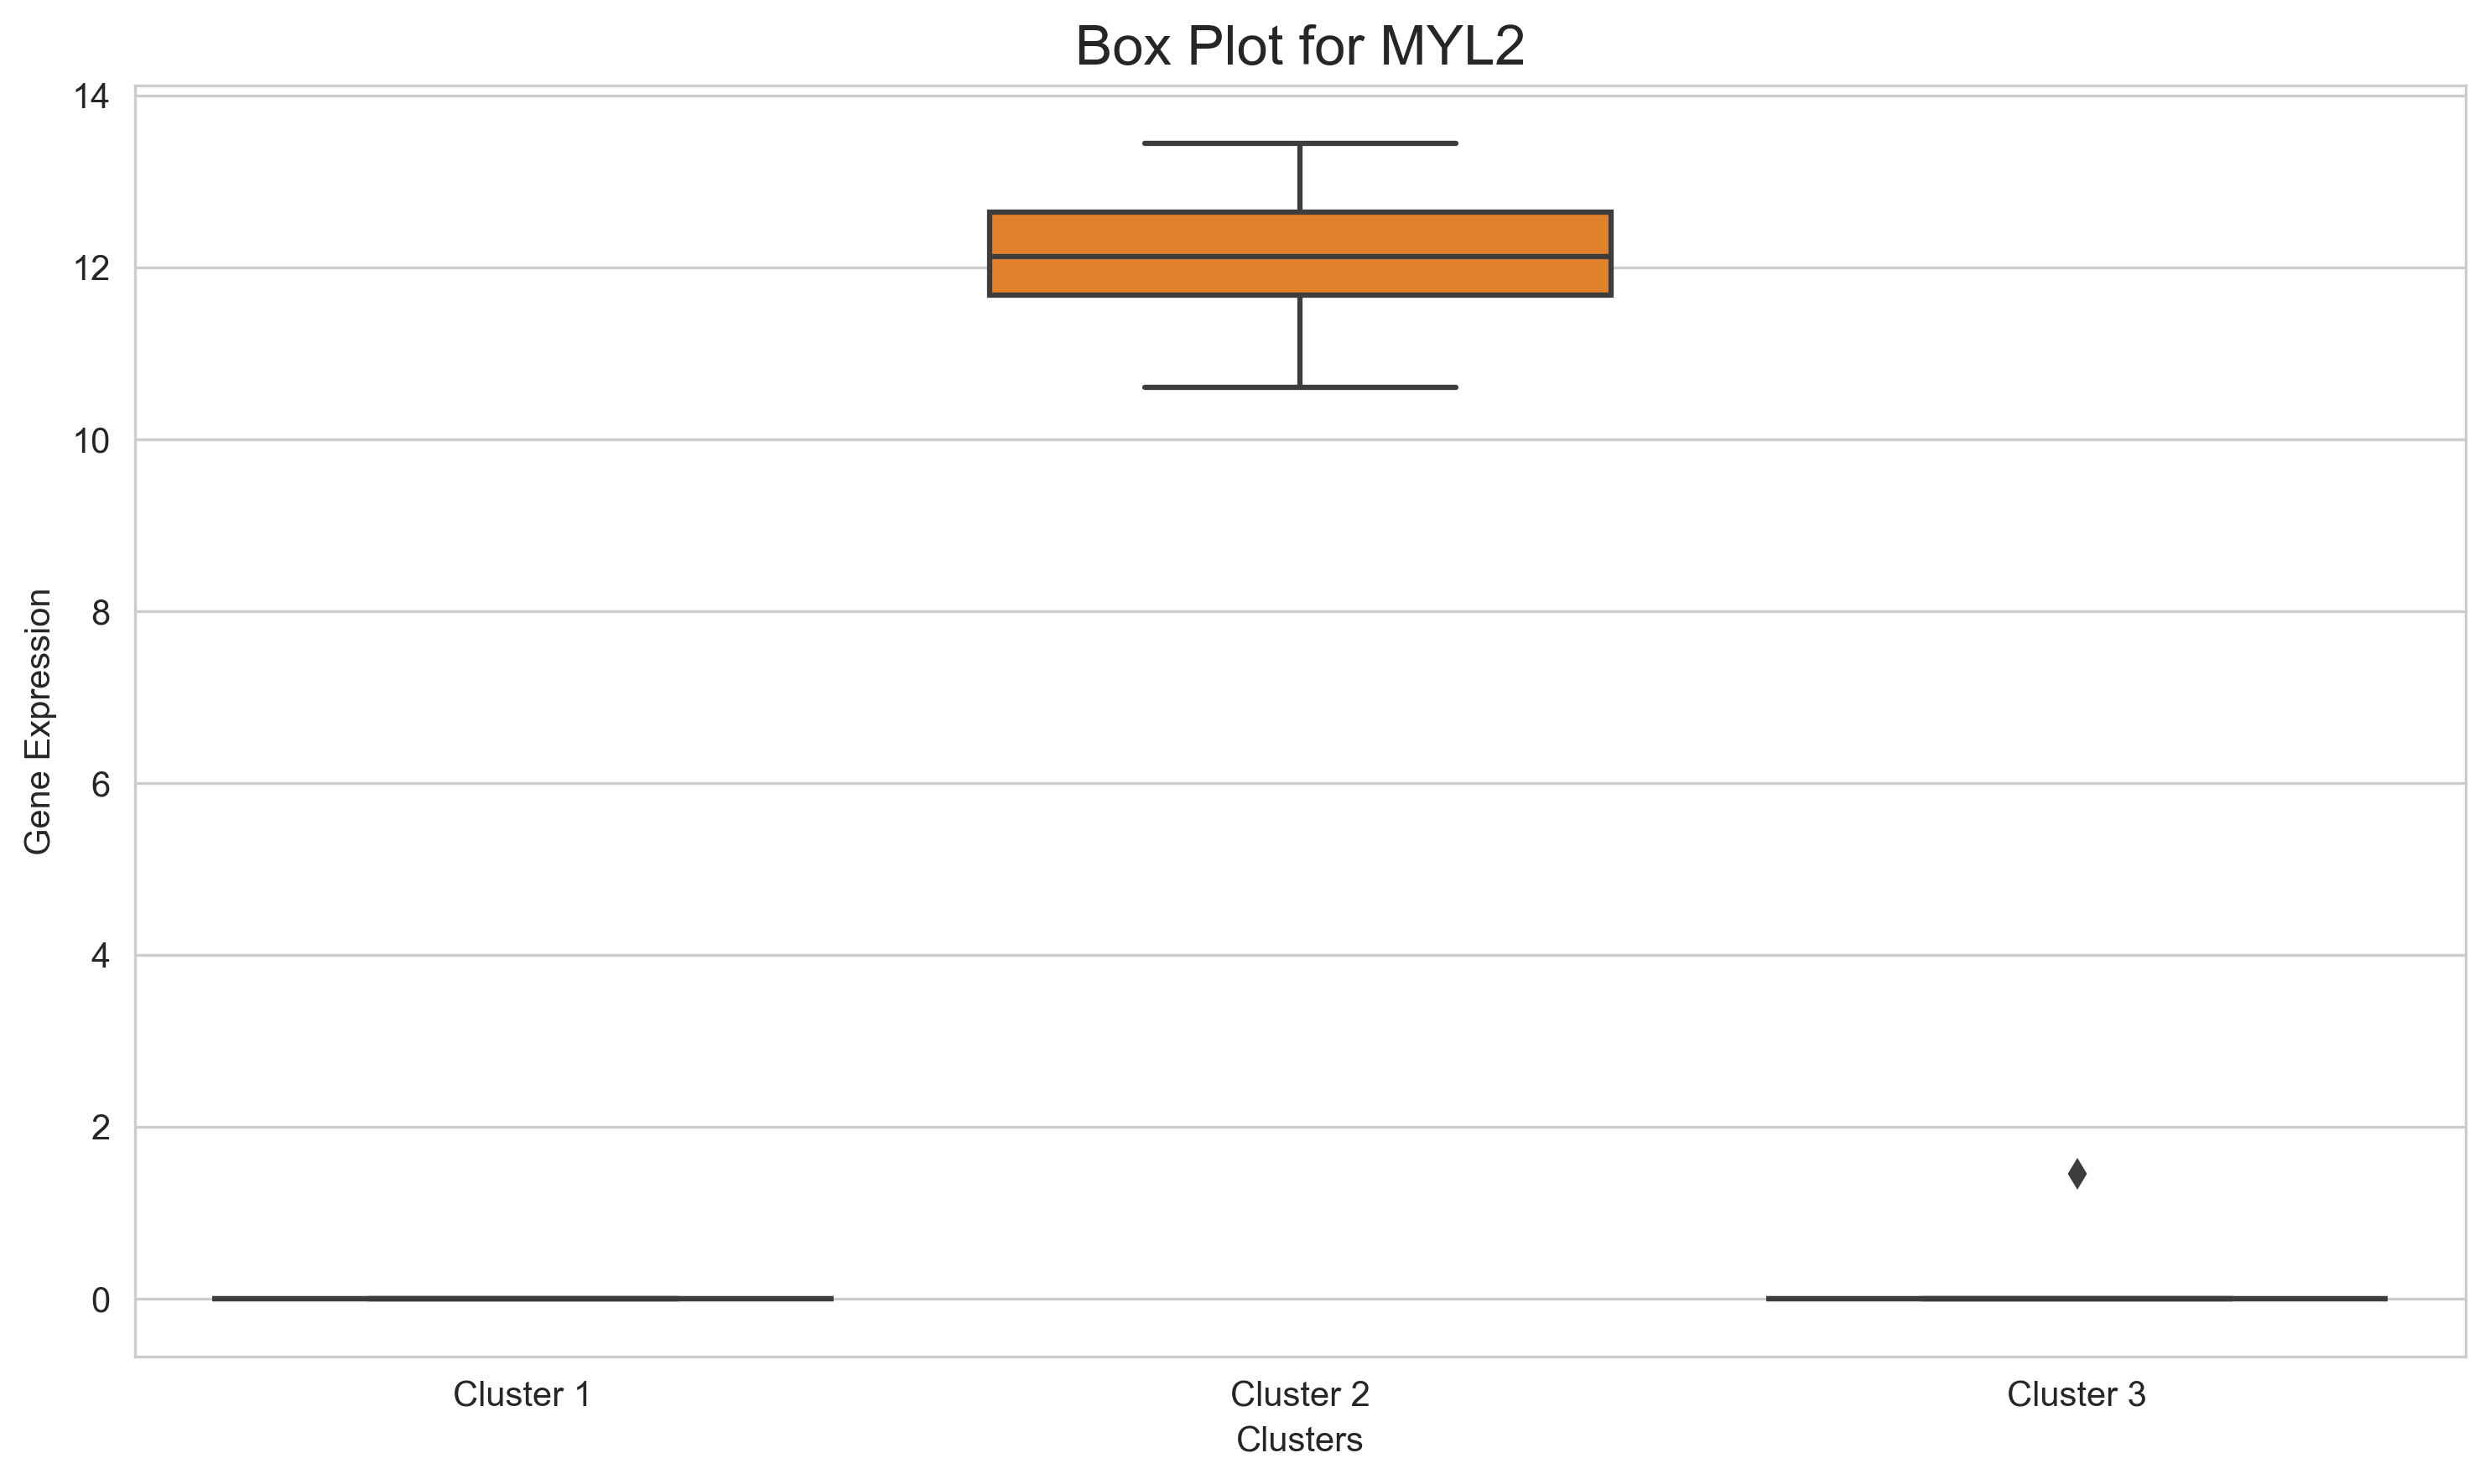

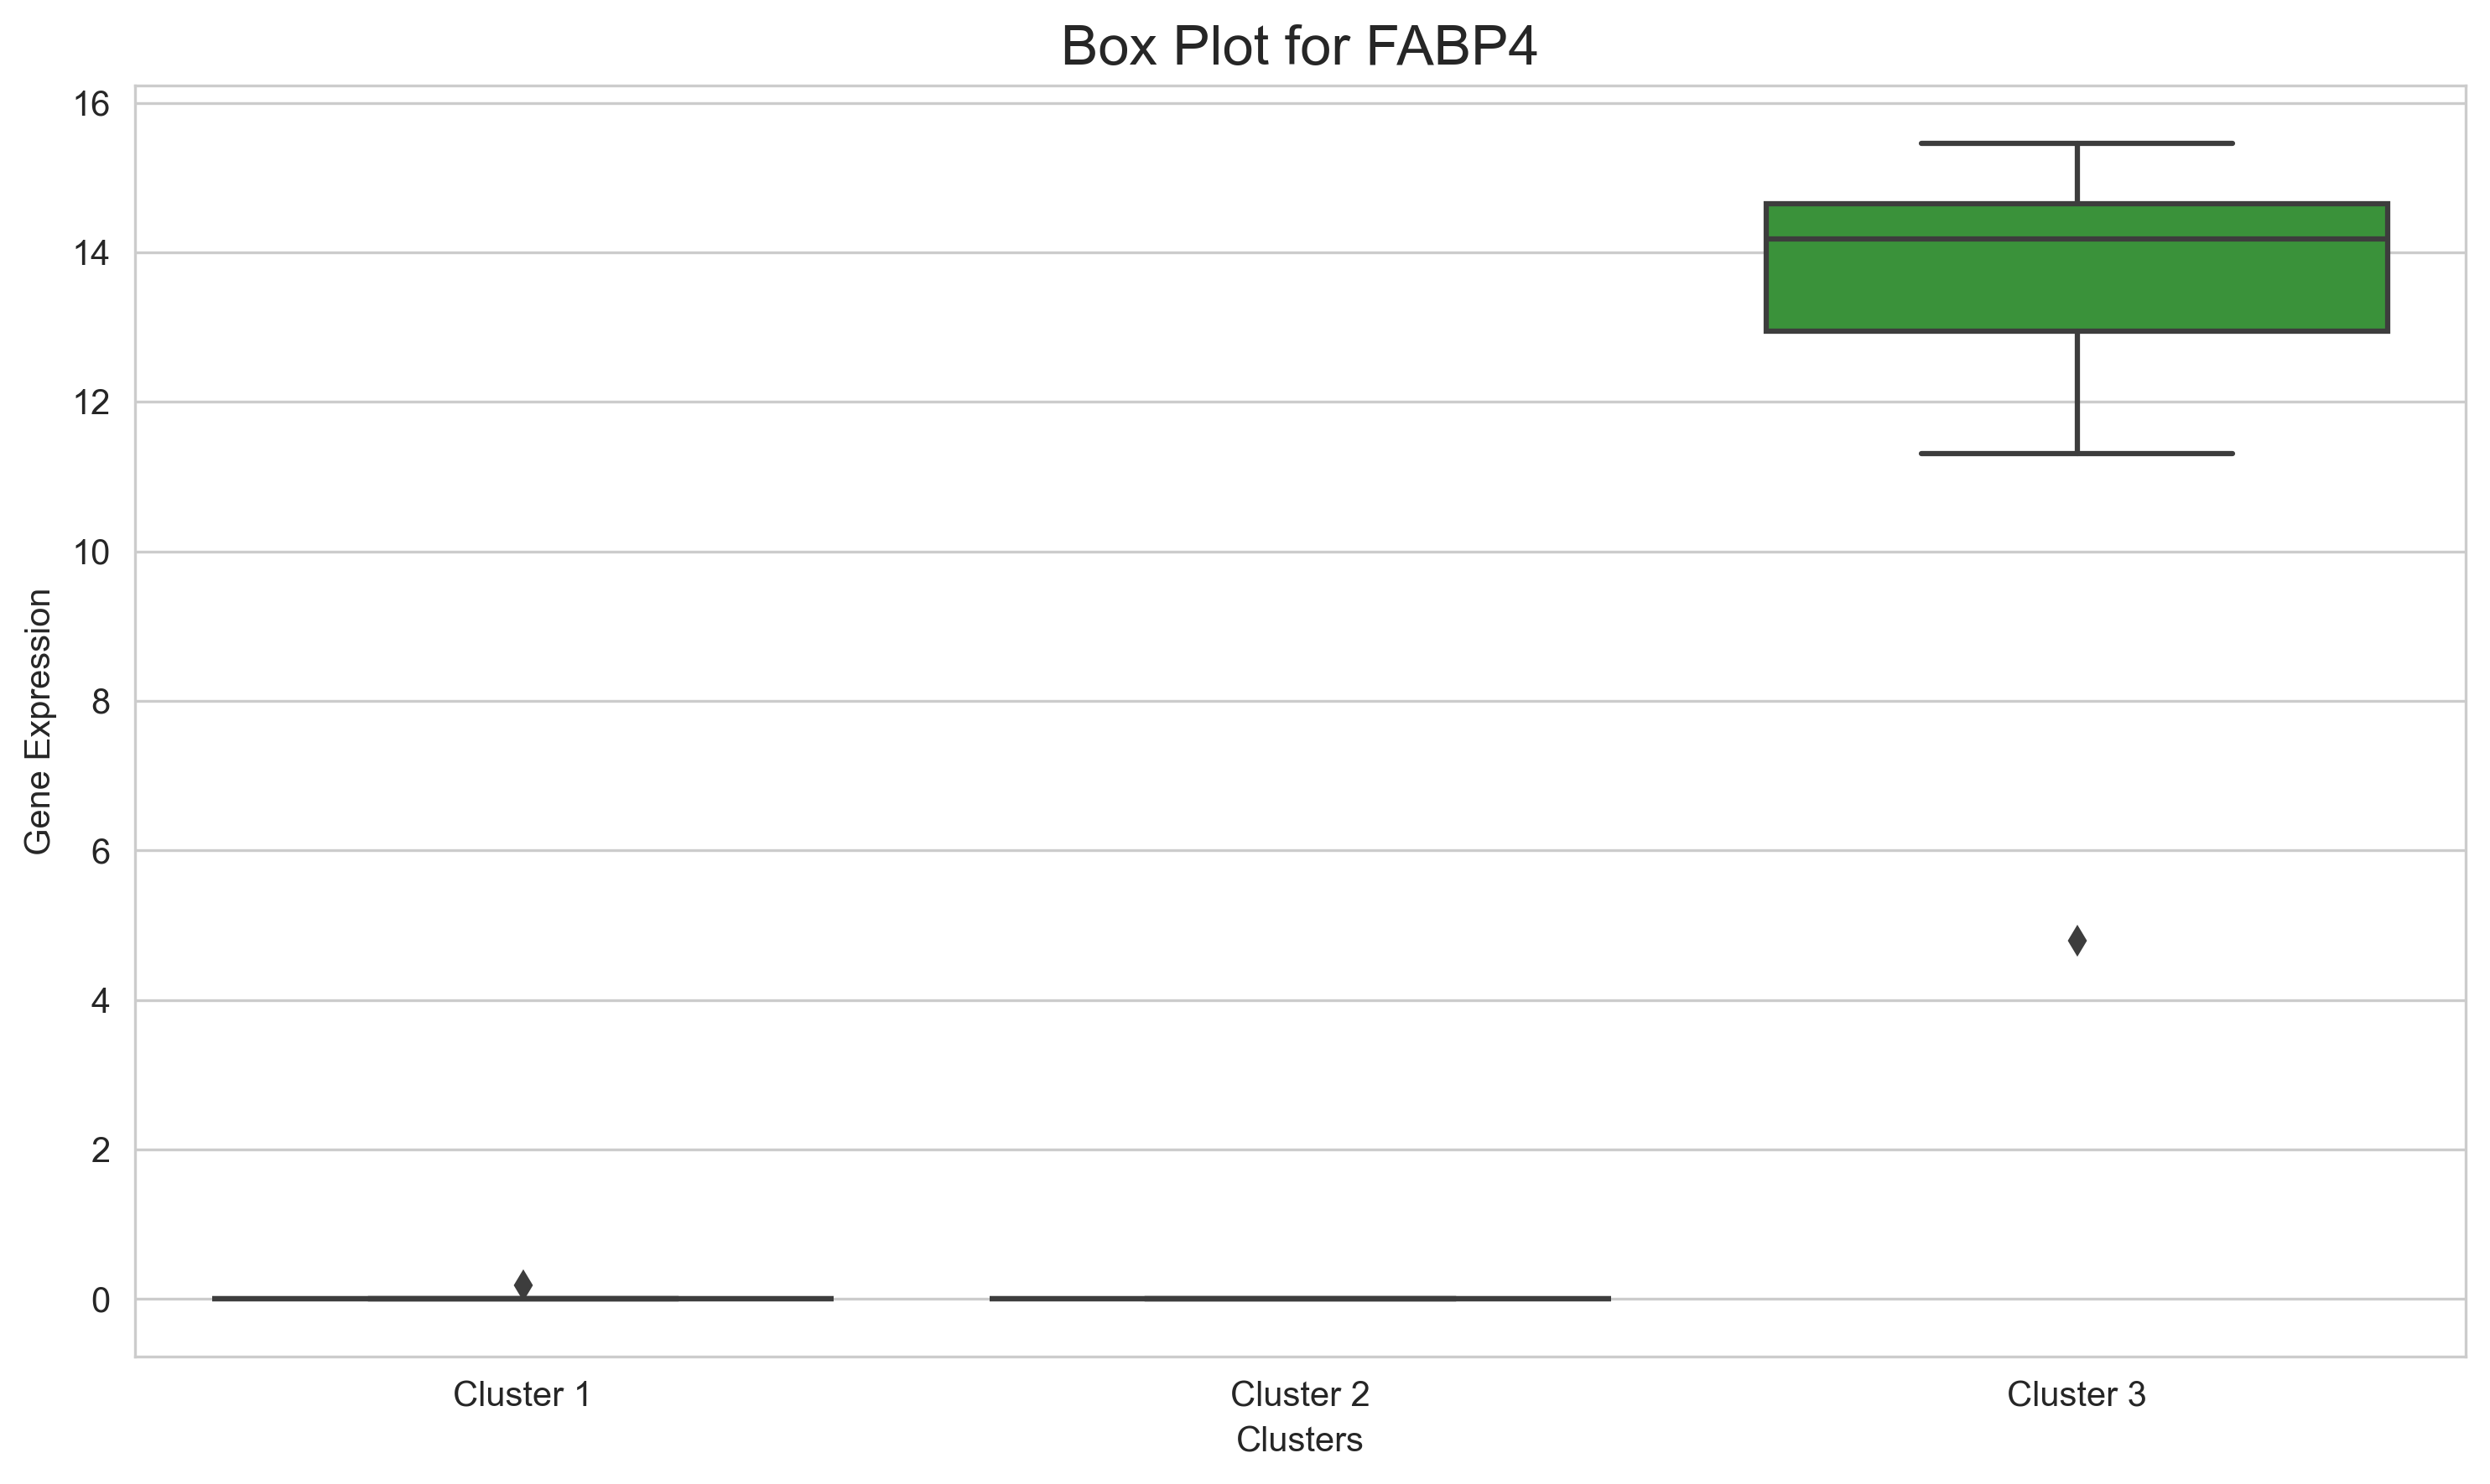

In [35]:
# Boxplot showing the gene expression of the cells in each of the three groups. Place the gene name in the title of the plot. 
for i in range(clusters):
    boxplot_gene_name(clusters, top_genes[i], gene_names_df[gene_names_df['gene_name'] == top_genes[i]]['Ensembl IDs'].values[0],cluster_series, data_matrix)

For each barplot, it is possible to see that the gene expression of the corresponding cluster is the highest, showing that the gene is a top gene for the corresponding cluster.

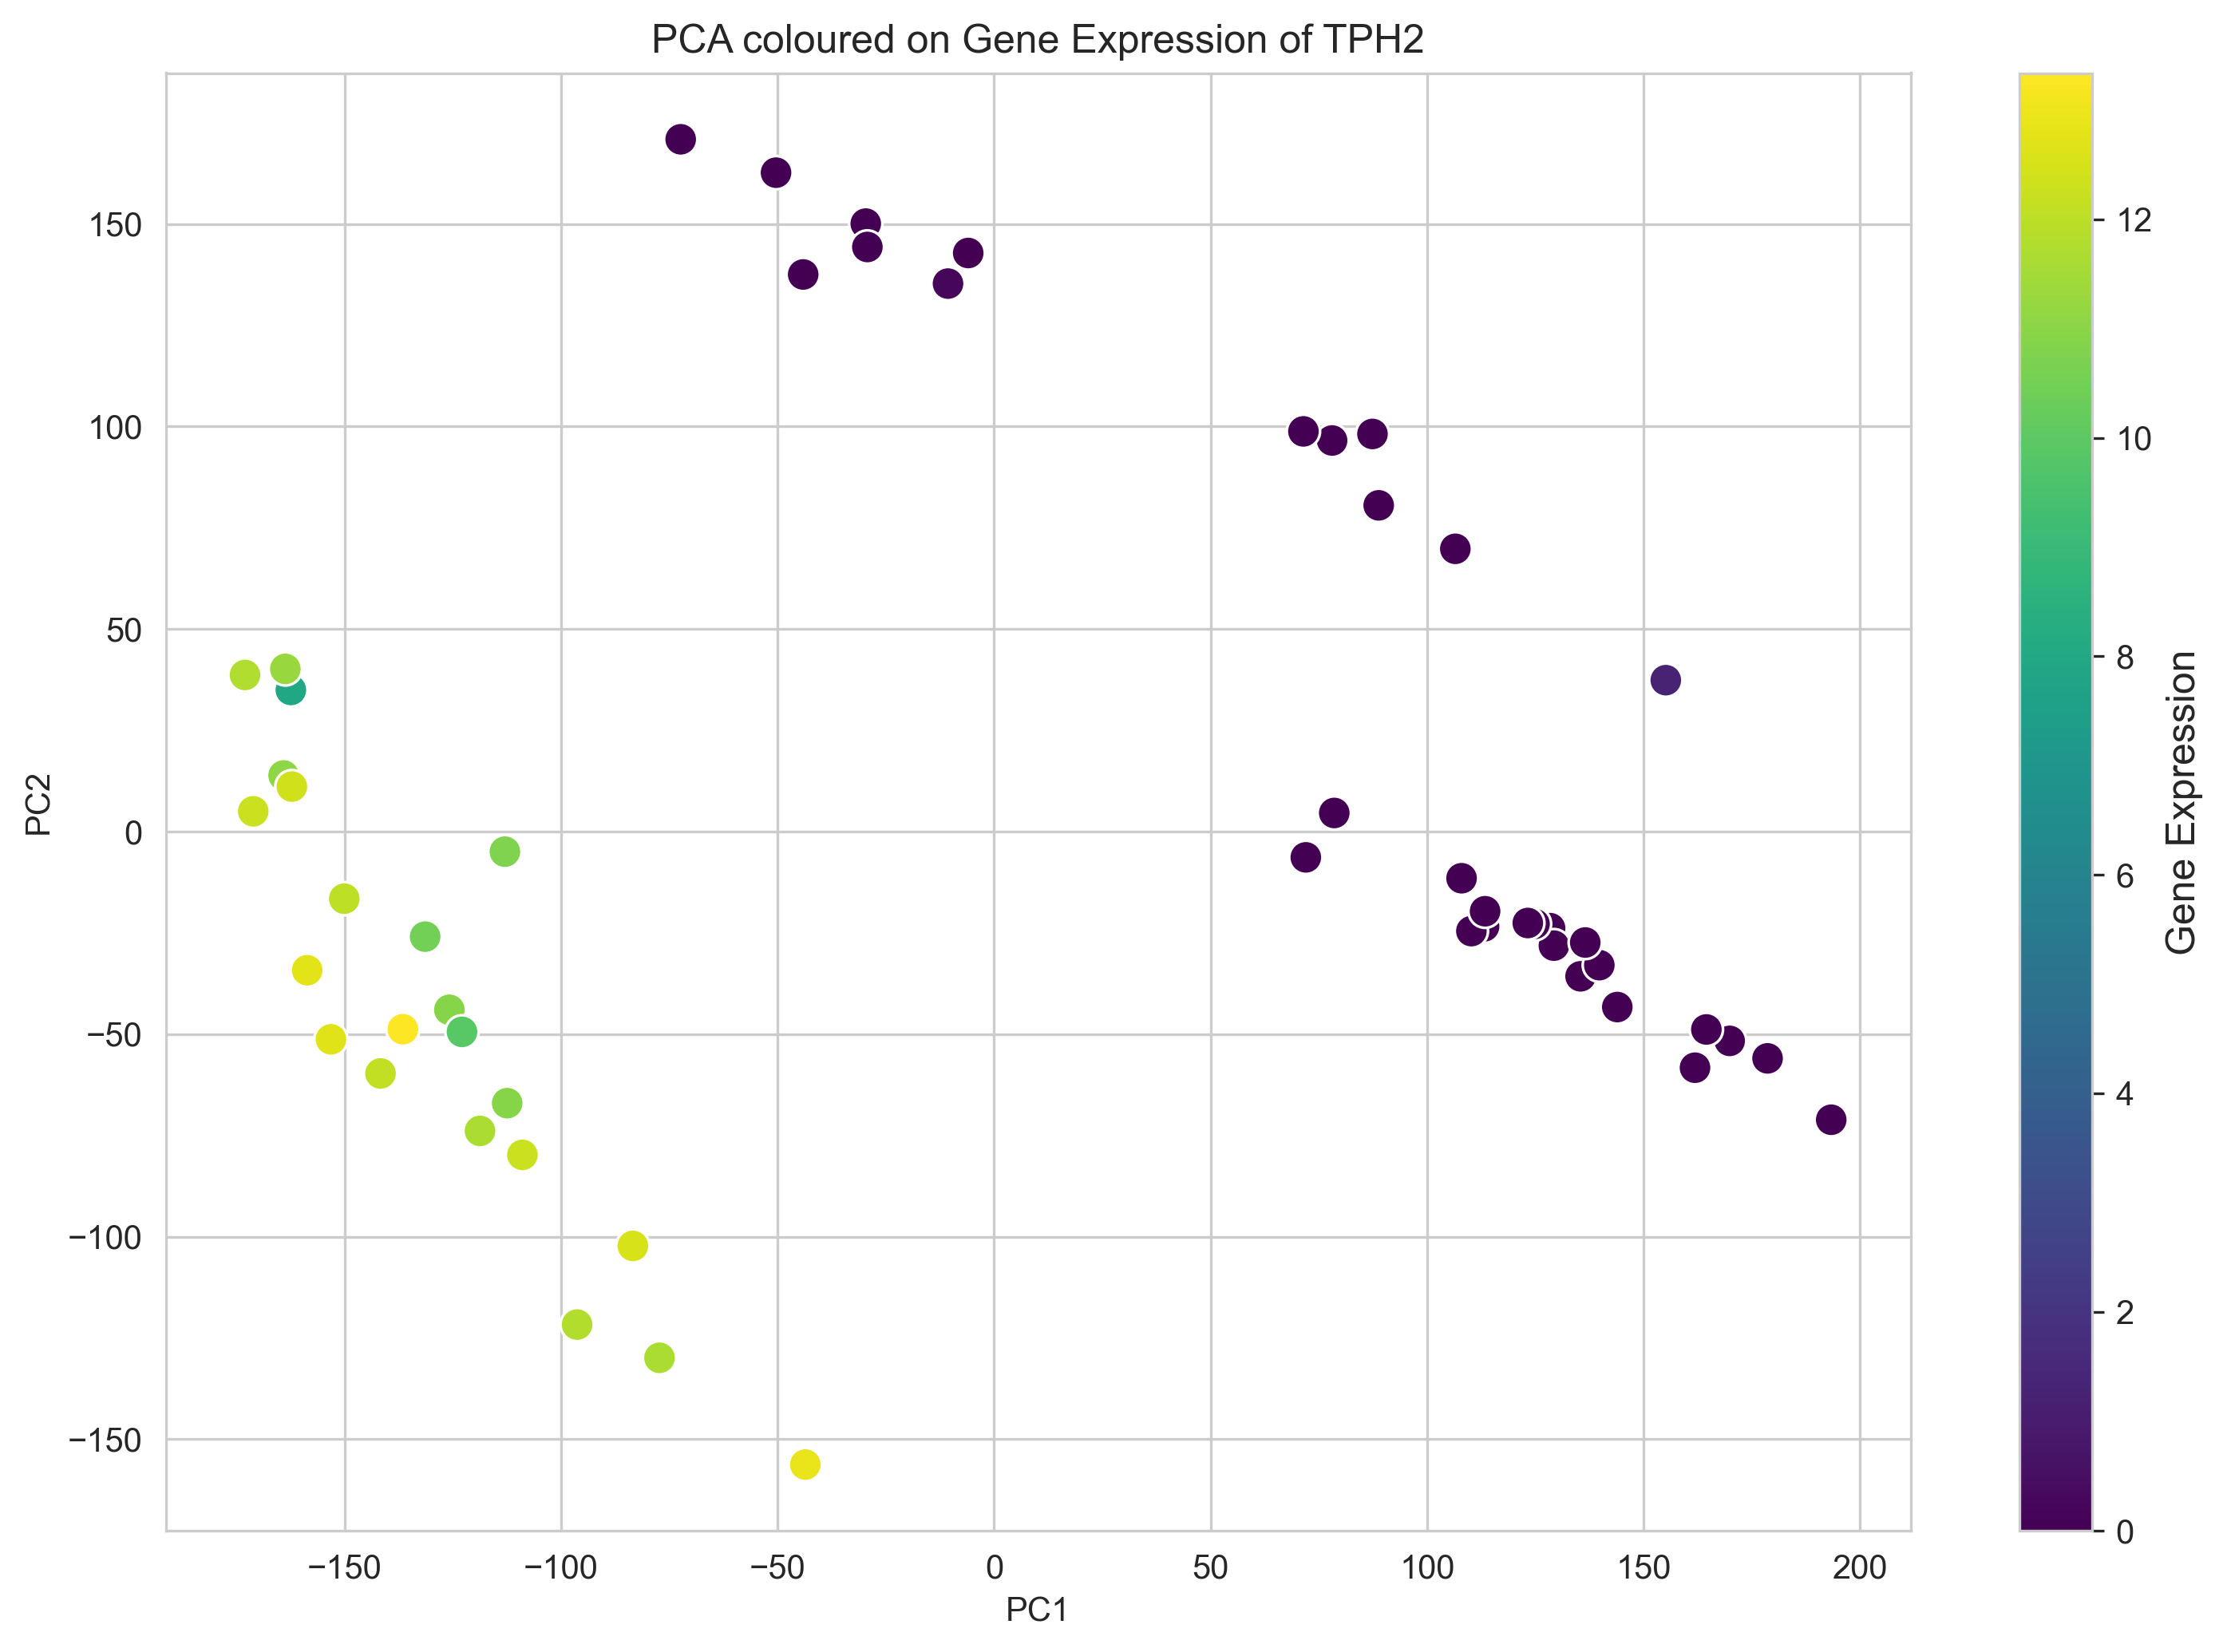

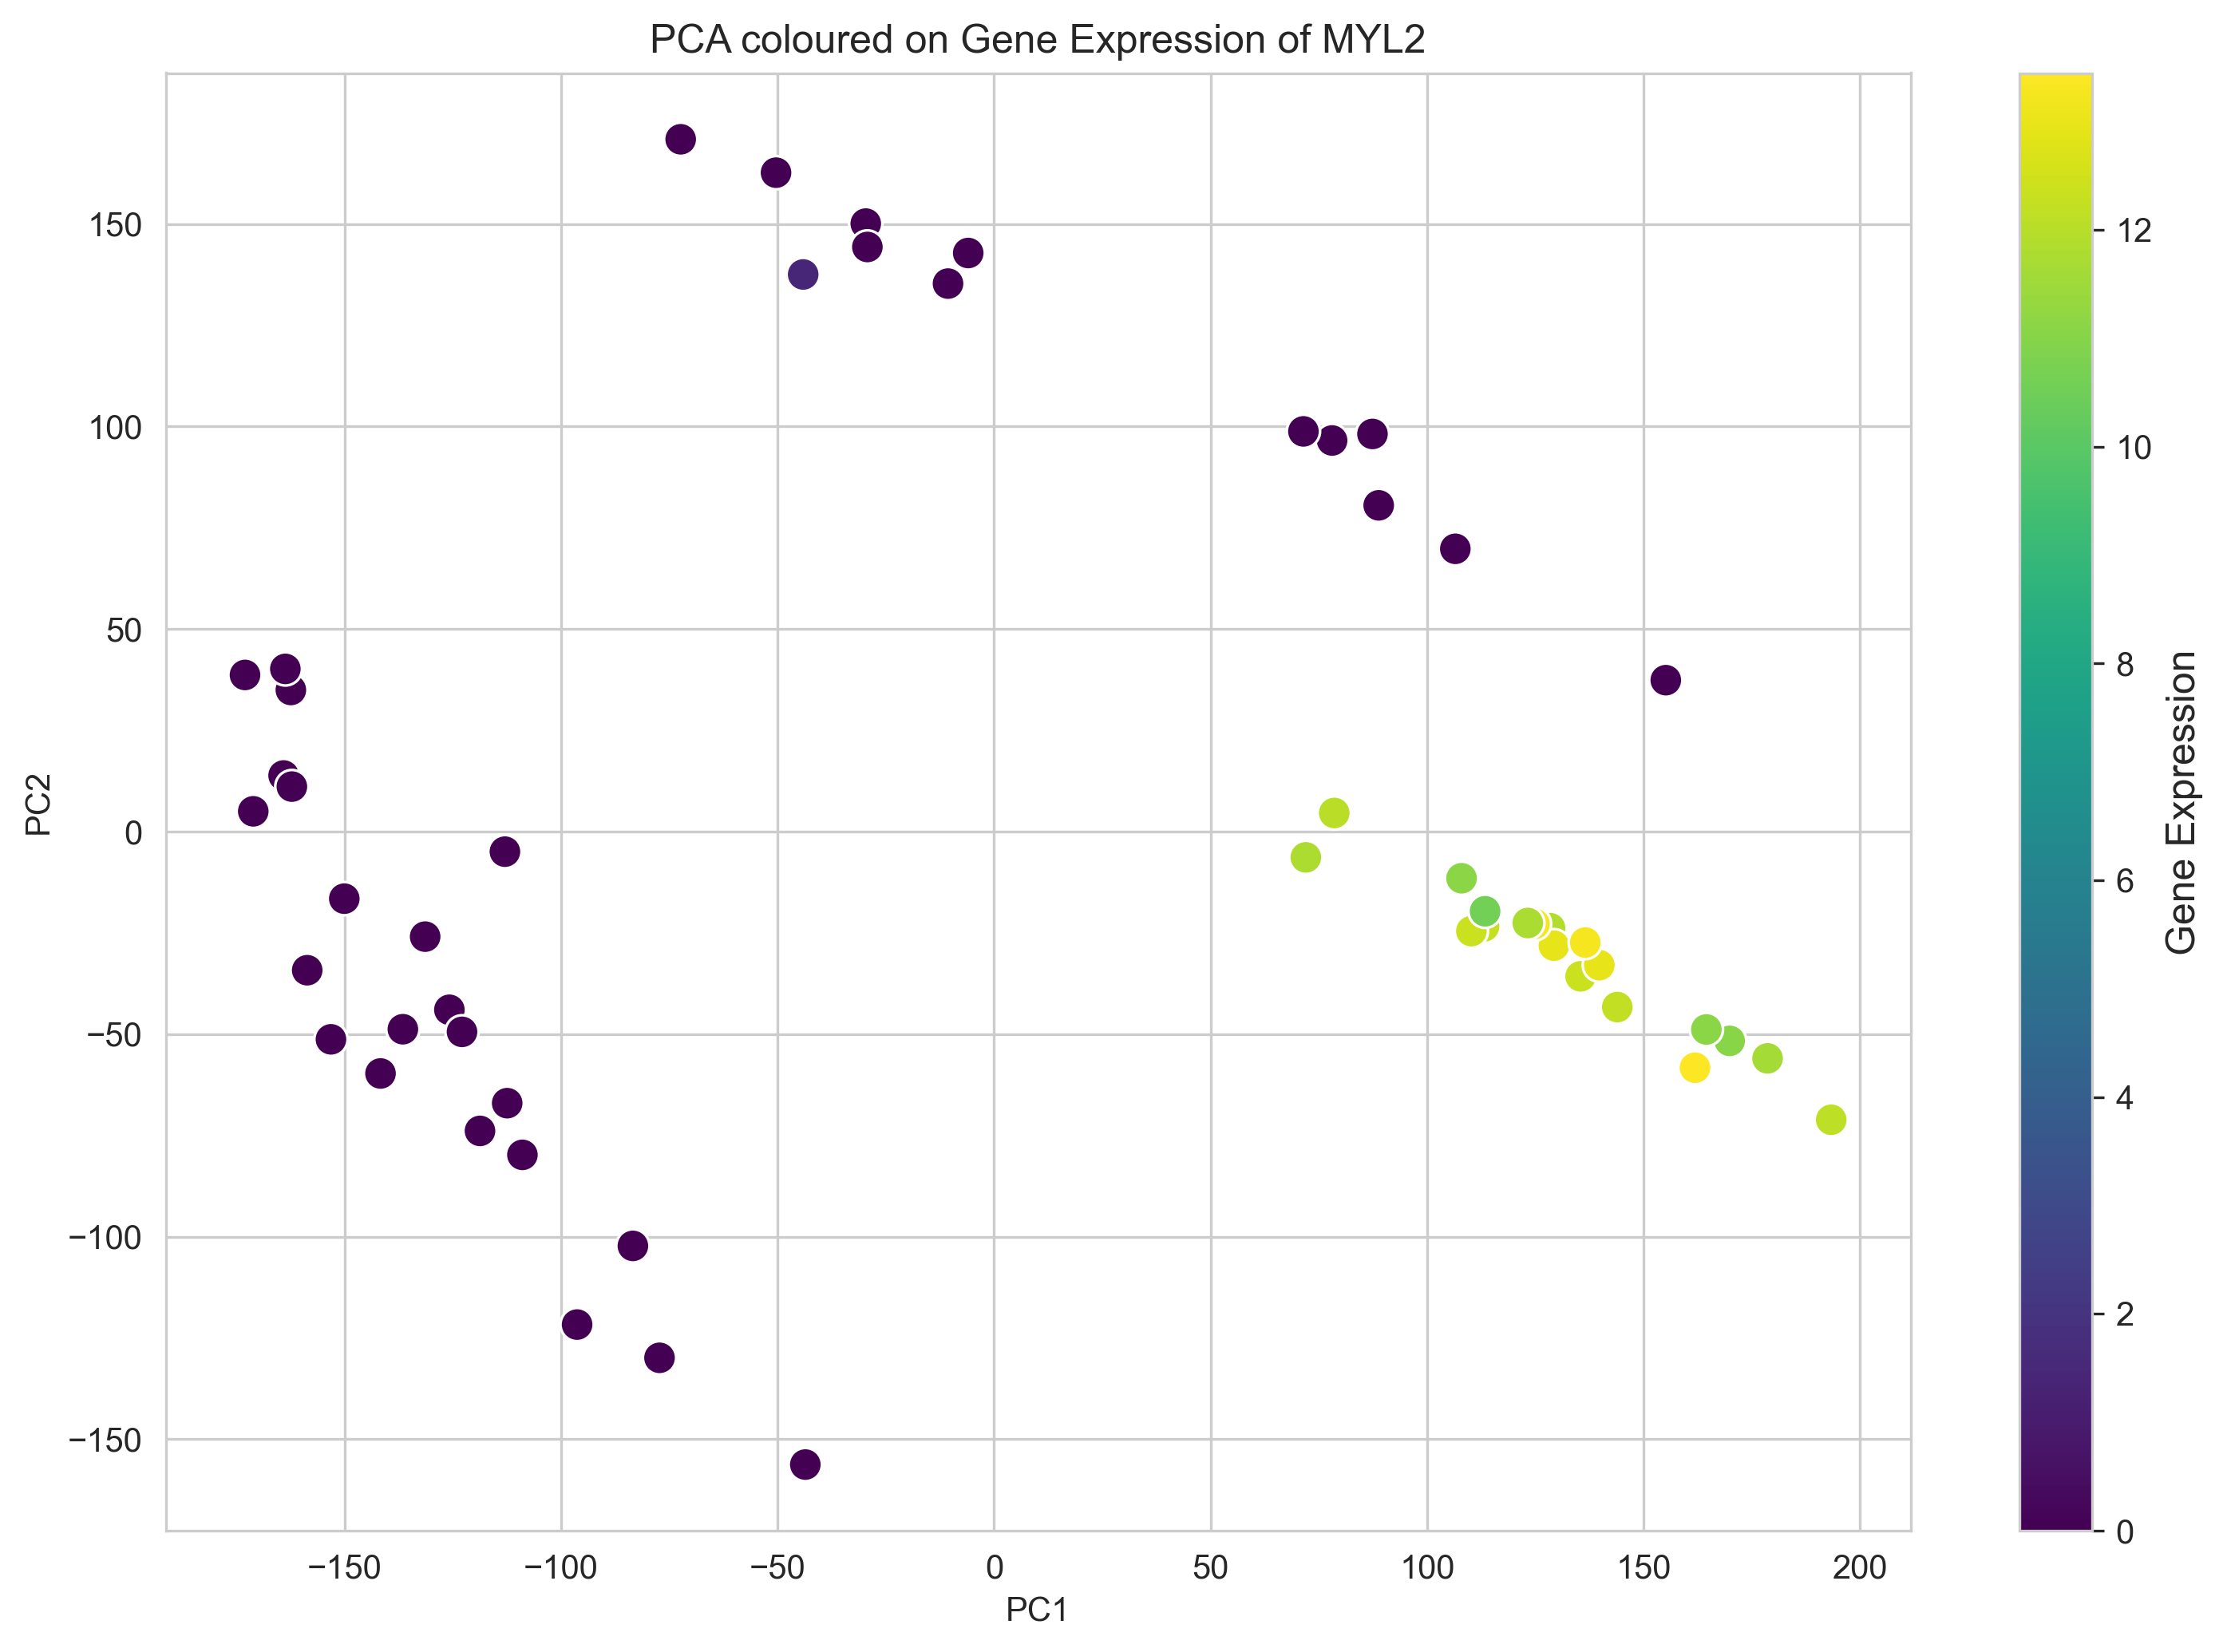

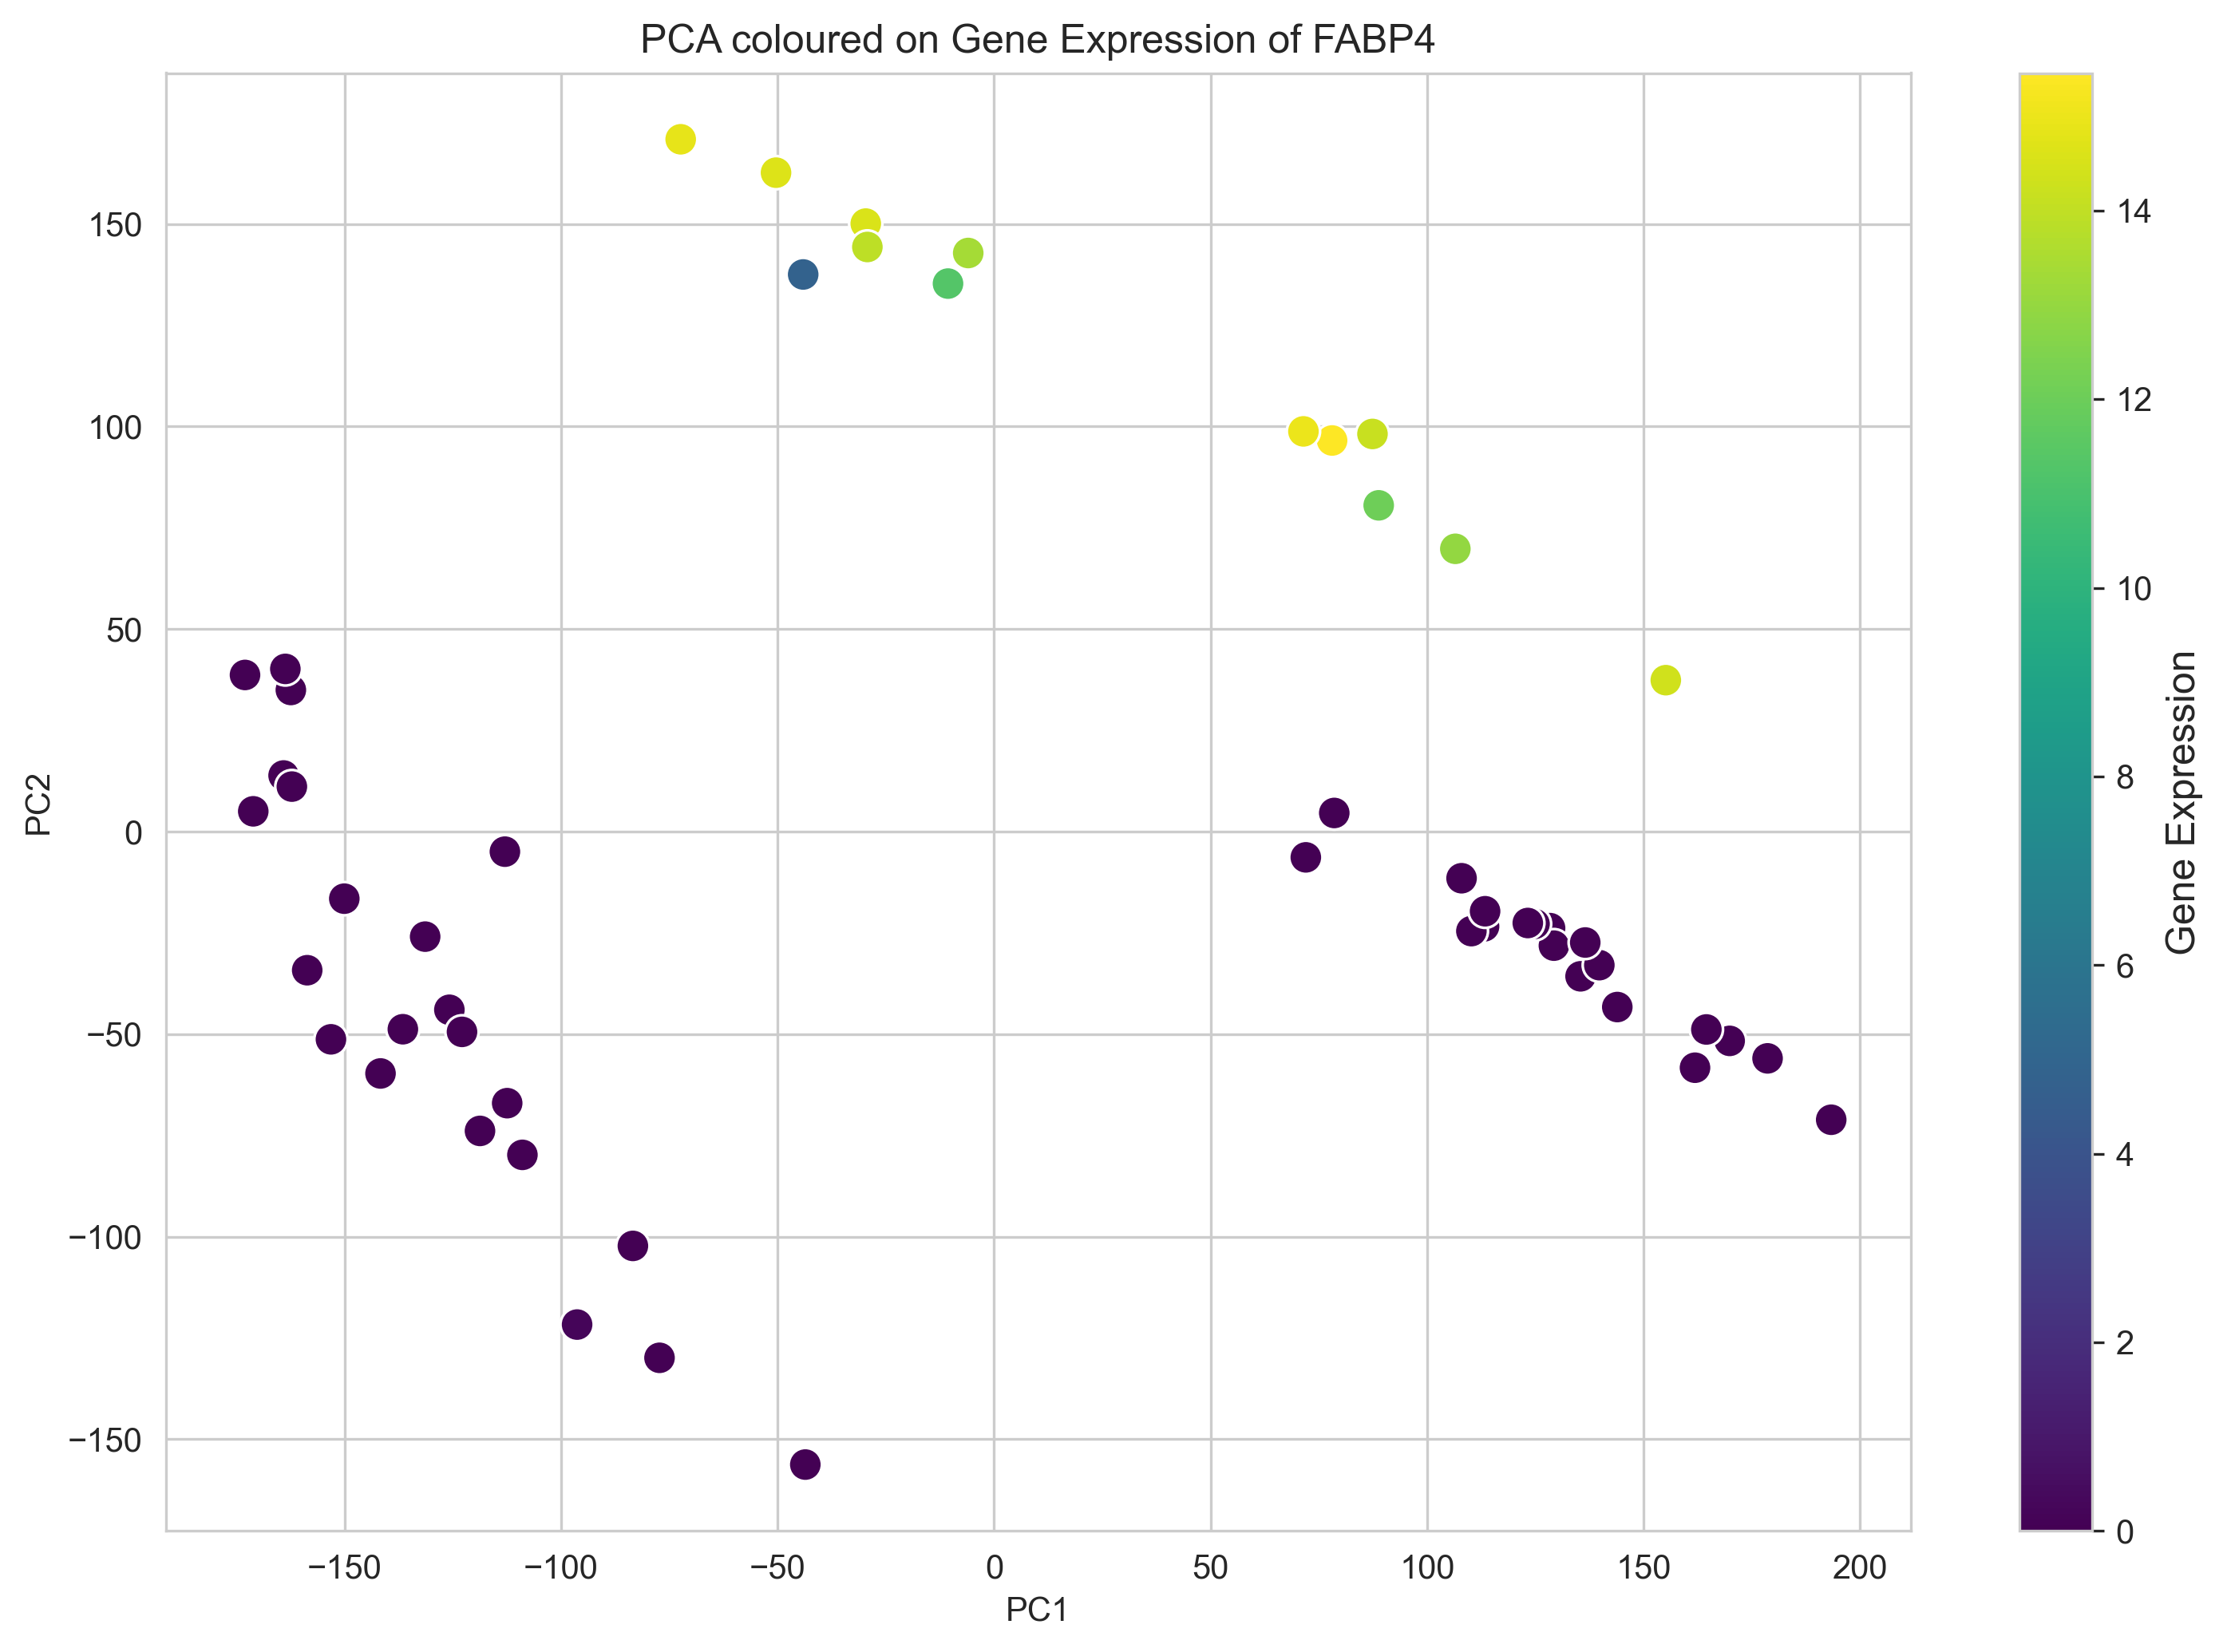

In [36]:
for i in range(clusters):
    ensembl_id = gene_names_df[gene_names_df['gene_name'] == top_genes[i]]['Ensembl IDs'].values[0]
    pca_cluster = pd.concat([transformed_df_cluster, data_matrix.loc[ensembl_id]], axis=1)
    title = f"PCA coloured on Gene Expression of {top_genes[i]}"
    name = f'pca_coloured_top_gene_{i + 1}.png'
    pca_plot(pca_cluster, title, name, hue=ensembl_id, legend=0)

For each plot, the gene expression of the corresponding cluster is the one with higher values, indicating that the corresponding gene is a top gene for that cluster.

### 3c) Identify the cell type corresponding to each group

In [37]:
# Find differentially expressed genes
differentially_expressed_genes = []
for i in range(clusters):
    differentially_rows = df_list[i][df_list[i]['fdr'] < fdr_threshold].sort_values(by='log2_fold_change', ascending=False)
    
    first_100 = differentially_rows.iloc[:200]['gene_name']
    last_100 = differentially_rows.iloc[-200:]['gene_name']
    
    differentially_expressed_genes.append(pd.concat([first_100, last_100]).values)

In [38]:
ENRICHR_URL = 'https://maayanlab.cloud/Enrichr'
ADD_LIST_ENDPOINT = "/addList"
ENRICH_ENDPOINT = "/enrich"

results = []
for i in range(clusters):
    genes_str = '\n'.join(differentially_expressed_genes[i])
    payload = {
    'list': genes_str,
    'description': 'Gene list analysis'
    }
    response = requests.post(
        ENRICHR_URL + ADD_LIST_ENDPOINT,
        files={'list': (None, genes_str)},
        data=payload
    )
    
    if not response.ok:
        raise Exception('Error uploading gene list')
    data = json.loads(response.text)
    user_list_id = data['userListId']
    
    query_string = f'{ENRICHR_URL}{ENRICH_ENDPOINT}?userListId={user_list_id}&backgroundType=CellMarker_2024'
    response = requests.get(query_string)
    
    if not response.ok:
        raise Exception('Error getting enrichment results')
    
    data = json.loads(response.text)
    results.append(data)


In [39]:
results[0]['CellMarker_2024'][:2]

[[1,
  'Neuron Brain Mouse',
  4.4545497115524574e-20,
  5.286919136856397,
  235.57335798999134,
  ['TOP2A',
   'SNAP25',
   'NRSN1',
   'DIRAS2',
   'STMN2',
   'CELF4',
   'STMN3',
   'CELF6',
   'MKI67',
   'SMC4',
   'ELAVL2',
   'RASGEF1A',
   'TUBB3',
   'MB',
   'KIF5C',
   'RESP18',
   'DNER',
   'KIF5A',
   'DSP',
   'PRMT8',
   'RBFOX3',
   'ELMOD1',
   'HPCAL4',
   'SYN1',
   'PCP4',
   'GAP43',
   'PRKAR1B',
   'LY6H',
   'RTN1',
   'SLC1A2',
   'CEND1',
   'PCDH17',
   'PCSK1N',
   'CAMK2N1',
   'DZANK1',
   'SLC12A5',
   'RRM2',
   'SYT1',
   'UBE2C',
   'GAD1',
   'ST8SIA3',
   'S100B',
   'GDAP1',
   'USP29',
   'IGF2R',
   'NFASC',
   'RALYL',
   'RIT2',
   'NSG2',
   'NASP',
   'DLG4',
   'CDK1',
   'ID3',
   'SPC25'],
  3.336457733952791e-17,
  0,
  0],
 [2,
  'Neural Progenitor Cell Embryonic Prefrontal Cortex Human',
  1.9325012530564626e-19,
  11.355231926620268,
  489.3003686490042,
  ['TOP2A',
   'SNAP25',
   'RAB3A',
   'RTN1',
   'NRXN1',
   'STMN2',
   'MKI6

The first cluster is Serotonergic neurons in the dorsal raphe nucleus

In [40]:
results[1]['CellMarker_2024'][3:6]

[[4,
  'Cardiomyocyte Heart Mouse',
  7.203053785030723e-13,
  55.81481481481482,
  1560.5320522951522,
  ['ACTC1',
   'CAV3',
   'ACTN2',
   'MB',
   'TNNC1',
   'TNNT2',
   'MYL3',
   'TNNI3',
   'MYH6',
   'TTN'],
  1.3343657136769414e-10,
  0,
  0],
 [5,
  'Cardiomyocyte Heart Human',
  1.0541269177028904e-12,
  36.921165381319625,
  1018.2232801225387,
  ['POPDC2',
   'MYBPC3',
   'MB',
   'MYL2',
   'TNNT2',
   'GATA6',
   'TNNI3',
   'CORIN',
   'MYH6',
   'TTN',
   'MYH7'],
  1.5622160920356834e-10,
  0,
  0],
 [6,
  'Cardiomyocyte Embryo Human',
  3.1216873555555933e-09,
  98000.0,
  1919319.4318982095,
  ['MYL7', 'MYL2', 'TNNT2', 'TNNI3', 'MYH7'],
  3.8552838841111577e-07,
  0,
  0]]

The second cluster is Heart myocardial tissue cell

In [41]:
results[2]['CellMarker_2024'][0]

[1,
 'Schwalie Et al.Nature.G4 Adipose Tissue Mouse',
 6.652418084560055e-14,
 8.446808510638299,
 256.2863983822796,
 ['IFITM3',
  'LGALS3BP',
  'RTP4',
  'ANXA1',
  'CSF1',
  'ANXA3',
  'STAT1',
  'ISG15',
  'IFI35',
  'IFIT1',
  'FBLN2',
  'USP18',
  'IFIT3',
  'PSMB8',
  'TGFBR2',
  'C4B',
  'BST2',
  'THBD',
  'TMEM158',
  'IRF7',
  'LGALS9',
  'XAF1',
  'GBP2',
  'GBP3'],
 4.1843709751882746e-11,
 0,
 0]

The third cluster is Fat Brown adipose tissue cells

### 3d) Heatmap

In [42]:
n_top_genes = 5
genes = []
for i in range(clusters):
    genes += list(differentially_expressed_genes[i][:n_top_genes])
    
filtered_df = gene_names_df[gene_names_df['gene_name'].isin(genes)]
gene_ids = filtered_df['Ensembl IDs'].tolist()

df_list_heatmap = []
for i in range(clusters):
    df_list_heatmap.append(df_list[i][df_list[i]['Ensembl IDs'].isin(gene_ids)]['log2_fold_change'])

data_map = pd.concat(df_list_heatmap, axis=1)
data_map.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3']
data_map.index = genes

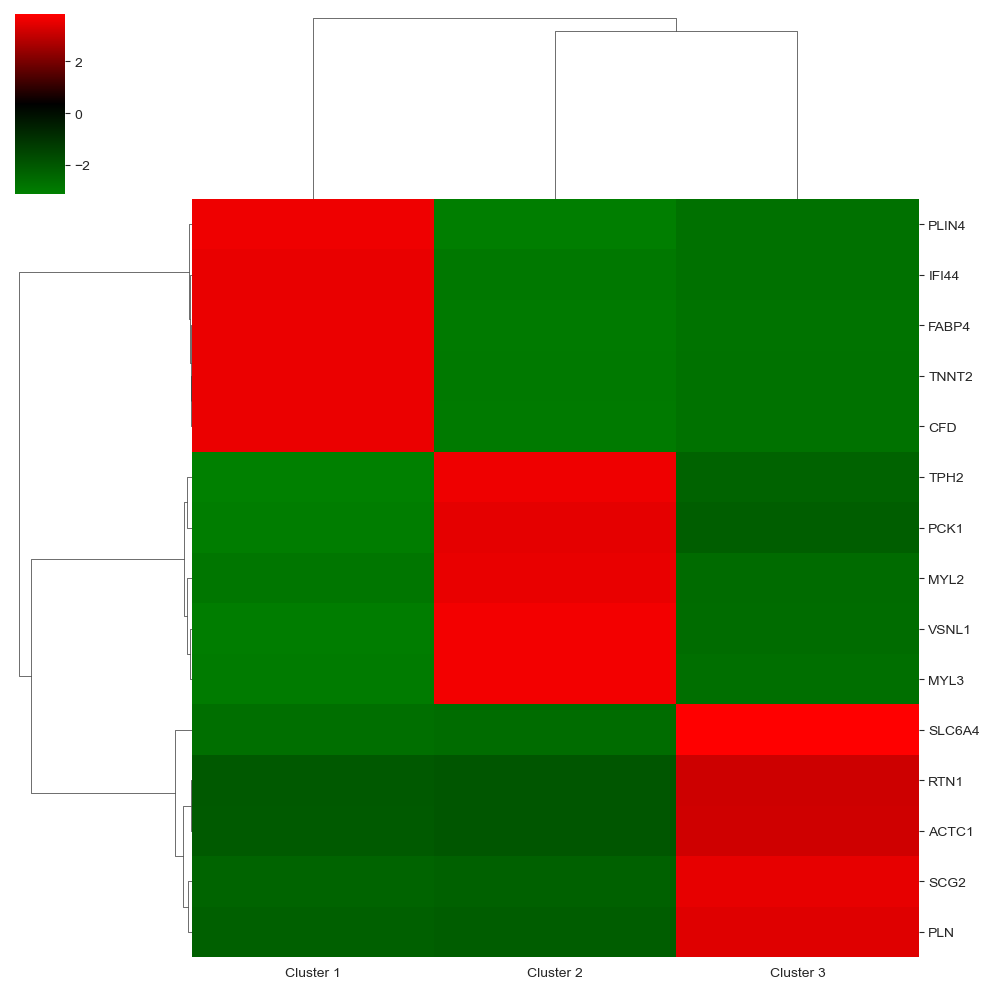

In [43]:
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["green", "black", "red"])
heatmap = sns.clustermap(data_map, cmap=custom_cmap)
heatmap.savefig(f'figures/heatmap.png', format="png", dpi=300)

The heatmap shows that the top 5 genes for each cluster are upregulated in that cluster compared to the other two. 